# Recommender Engine for CareerVillage

## Table of Content
1. [Introduction](#introduction)
2. [Data Overview](#data_overview)
3. [Set Up](#set_up)
4. [EDA](#eda)
5. [NLP](#nlp)
    1. [Doc2Vec](#nlp_doc2vec)
    2. [LDA](#nlp_lda)
6. [Feature Engineering](#feature_engineering)
7. [Data Ingestion](#di)
    1. [Additional Data Computation](#di_add_data_comp)
    1. [Batch Generator](#di_batch_generator)
8. [Neural Netwrok Architecture](#nna)
    1. [General Idea](#nna_general_idea)
    2. [Simple explanation](#nna_simple_explanation)
    3. [Training](#nna_training)
    4. [Evaluation](#nna_evaluation)
    4. [Test](#nna_test)
9. [Recommendation Engine](#re)
    1. [Intro](#re_intro)
    2. [Content Based](#re_content_based)
    3. [Activity Based](#re_activity_based)
    4. [Probabilistic Approach](#re_probabilistic_approach)
    5. [Suggestion on Reinforcement Learning Approach](#re_rla)
10. [Deployment](#de)
    1. [Project Source Code](#de_psc)
    2. [Demo](#de_demo)
11. [Future Plans](#fp)

## 1. Introduction <a id="introduction"></a>
With this notebook we would like to show our approach for a new recommendation engine at www.careervillage.org.
The main goal here is to develop a method to recommend relevant questions to the professionals who are most likely to answer them.

Description of solution:
- Method for taking into account all the possible content features using custom Neural Network Architecture. Allows automatically find a probability mapping between question and professional entities in all of the combinations (que-que, que-pro, pro-que, pro-pro). It is trained in a way that even without any information about professional and his activity, it still recommends questions, and breaks cold start problem having its own internal scoring.
- Method *activity_filter* for filtering out all the inactive professionals in order to send immediate emails to professionals who are most likely answer the question, and answer it fast
- Methods *spam_filter* and *email_filter* for sending emails which allows to handle spam problem and controls frequency and amount of emails for each professional based on his personal emails reaction type and speed (here reaction==answer)
- The method which tries to activate inactive and "cold" professionals by breaking *activity_filter* and *email_filter* with some probability. This is needed for making an attempt to activate the user or remind him about relevant questions which were already sent to him.
- Suggestions and ideas for RL approach, environment modeling, and reward engineering to handle complex metrics
- Code available for deployment
- Live Demo with NN based fast similarity search

Content Table Description:
- **Data overview** section shows us the data diagram and highlights the main and secondary data.
- **Set Up** section is for loading all necessary libraries, setting globals and loading CSV files.
- **EDA** section is for the insights, but we did it as simple and short as possible - as there are already a lot of existing notebooks sharing different insights
- **NLP** section is for useful extraction data from text
- **Feature Engineering** section is dedicated to the creation of new feature-columns for further usage in EDA and modeling.
- **Data Ingestion** mainly for batch generator
- **Neural Network Architecture** to combine so-called content feature for solving the problem, only based on static data provided by professional and student as well as the content of the question itself
- **The Recommendation Engine** - problem solution
- **Deployment** - test it fast and easy
- **Future Plans** are for dreams :)

## 2. Data Overview <a id="data_overview"></a>
Below you can find the diagram with data and relations.
Essential primary entities are "Professional", "Student", "Question" and "Answer".
The most useful secondary entity is "Tag."

Primary and secondary entities are used to create so-called "content" features.
Other data is divided into two main parts "activity" and "time" features.

![data overview](https://drive.google.com/uc?id=1QdxvAXep1_kJX_CzpGnwkGz3qE6_pgkc)

## 3. Set Up <a id="set_up"></a>

### Libraries

In [1]:
import os
import copy
import datetime
import warnings

import random
from datetime import datetime
import re

import numpy as np
from scipy.stats import t
import pandas as pd
import keras

from matplotlib import pyplot as plt
import matplotlib as mpl

from wordcloud import WordCloud

import seaborn as sns


Using TensorFlow backend.


### Globals & Settings

In [2]:
np.random.seed(42)

pd.set_option('display.max_columns', 100, 'display.width', 1024)
pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

mpl.rcParams['axes.facecolor'] = '#12162f'
plt.grid(False)
plt.close()

DATA_PATH = '../input/'
SPLIT_DATE = '2019-01-01'

### CSV Files

In [3]:
# Read CSV casitng dates
answers = pd.read_csv(os.path.join(DATA_PATH, 'answers.csv'))
answer_scores = pd.read_csv(os.path.join(DATA_PATH, 'answer_scores.csv'))
comments = pd.read_csv(os.path.join(DATA_PATH, 'comments.csv'))
emails = pd.read_csv(os.path.join(DATA_PATH, 'emails.csv'))
groups = pd.read_csv(os.path.join(DATA_PATH, 'groups.csv'))
group_memberships = pd.read_csv(os.path.join(DATA_PATH, 'group_memberships.csv'))
matches = pd.read_csv(os.path.join(DATA_PATH, 'matches.csv'))
professionals = pd.read_csv(os.path.join(DATA_PATH, 'professionals.csv'))
questions = pd.read_csv(os.path.join(DATA_PATH, 'questions.csv'))
question_scores = pd.read_csv(os.path.join(DATA_PATH, 'question_scores.csv')) 
school_memberships = pd.read_csv(os.path.join(DATA_PATH, 'school_memberships.csv'))
students = pd.read_csv(os.path.join(DATA_PATH, 'students.csv'))
tags = pd.read_csv(os.path.join(DATA_PATH, 'tags.csv'))
tag_questions = pd.read_csv(os.path.join(DATA_PATH, 'tag_questions.csv'))
tag_users = pd.read_csv(os.path.join(DATA_PATH, 'tag_users.csv'))

## 4. EDA <a id="eda"></a> 

#### Datetimes features preprocessing

In [4]:
answers['answers_date_added'] = pd.to_datetime(answers['answers_date_added'], infer_datetime_format=True)
comments['comments_date_added'] = pd.to_datetime(comments['comments_date_added'], infer_datetime_format=True)
emails['emails_date_sent'] = pd.to_datetime(emails['emails_date_sent'], infer_datetime_format=True)
professionals['professionals_date_joined'] = pd.to_datetime(professionals['professionals_date_joined'], infer_datetime_format=True)
questions['questions_date_added'] = pd.to_datetime(questions['questions_date_added'], infer_datetime_format=True)
students['students_date_joined'] = pd.to_datetime(students['students_date_joined'], infer_datetime_format=True)

In [5]:
answers[['answers_date_added']].head(1)

,answers_date_added
0,2016-04-29 19:40:14


#### Activity features used in EDA
User activities divided into 3 main categories:
- Answer
- Question
- Comment

Time of these activities helps us to derive essential features such us *date_last_activity* which is used later on in activity based recommendation decisions

In [6]:
# Last Answer
temp = answers.groupby('answers_author_id')['answers_date_added'].max()
professionals['date_last_answer'] = pd.merge(professionals, pd.DataFrame(temp.rename('last_answer')), left_on='professionals_id', right_index=True, how='left')['last_answer']
# First Answer
temp = answers.groupby('answers_author_id')['answers_date_added'].min()
professionals['date_first_answer'] = pd.merge(professionals, pd.DataFrame(temp.rename('first_answer')), left_on='professionals_id', right_index=True, how='left')['first_answer']
# Last Comment
temp = comments.groupby('comments_author_id')['comments_date_added'].max()
professionals['date_last_comment'] = pd.merge(professionals, pd.DataFrame(temp.rename('last_comment')), left_on='professionals_id', right_index=True, how='left')['last_comment']
# First Comment
temp = comments.groupby('comments_author_id')['comments_date_added'].min()
professionals['date_first_comment'] = pd.merge(professionals, pd.DataFrame(temp.rename('first_comment')), left_on='professionals_id', right_index=True, how='left')['first_comment']
# Last Activity
professionals['date_last_activity'] = professionals[['date_last_answer', 'date_last_comment']].max(axis=1)
# First Activity
professionals['date_first_activity'] = professionals[['date_first_answer', 'date_first_comment']].min(axis=1)

# Last activity (Question)
temp = questions.groupby('questions_author_id')['questions_date_added'].max()
students['date_last_question'] = pd.merge(students, pd.DataFrame(temp.rename('last_question')), left_on='students_id', right_index=True, how='left')['last_question']
# First activity (Question)
temp = questions.groupby('questions_author_id')['questions_date_added'].min()
students['date_first_question'] = pd.merge(students, pd.DataFrame(temp.rename('first_question')), left_on='students_id', right_index=True, how='left')['first_question']
# Last activity (Comment)
temp = comments.groupby('comments_author_id')['comments_date_added'].max()
students['date_last_comment'] = pd.merge(students, pd.DataFrame(temp.rename('last_comment')), left_on='students_id', right_index=True, how='left')['last_comment']
# First activity (Comment)
temp = comments.groupby('comments_author_id')['comments_date_added'].min()
students['date_first_comment'] = pd.merge(students, pd.DataFrame(temp.rename('first_comment')), left_on='students_id', right_index=True, how='left')['first_comment']
# Last activity (Total)
students['date_last_activity'] = students[['date_last_question', 'date_last_comment']].max(axis=1)
# First activity (Total)
students['date_first_activity'] = students[['date_first_question', 'date_first_comment']].min(axis=1)


Professionals emails for spam emails filtering

In [7]:
pro_emails = pd.merge(professionals, emails, how='inner', left_on='professionals_id', right_on='emails_recipient_id')
pro_emails = pro_emails[pro_emails['emails_frequency_level'] == 'email_notification_immediate']
pro_emails = pro_emails[['professionals_id', 'emails_id', 'emails_date_sent']]

pro_email_ques = pro_emails.merge(matches, left_on='emails_id', right_on='matches_email_id')
pro_email_ques = pro_email_ques.drop(columns=['emails_id', 'matches_email_id']) \
                 .set_index('professionals_id').rename(columns={'matches_question_id': 'questions_id'})

### Plots & Insights <a id="eda_plots"></a> 

### Users Missing Data
Professionals highly use the *Location*, *Industry*, *Headline* and *Tags*. These features are included in our Content Model for recommendations as well as a *Location* of the students.

*Groups*, *Schools* and *Comments* rarely used by both types of users.

Students rarely use *Tags*.

Near 0.6 both from students and professionals are not posting *Questions* and *Answers* correspondingly.

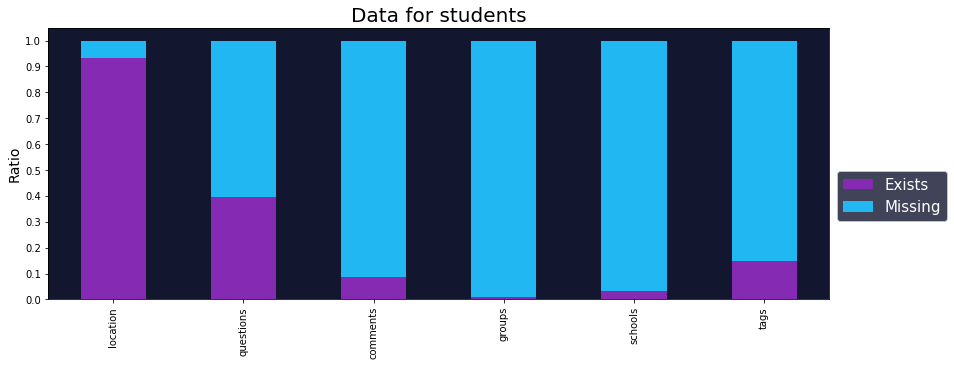

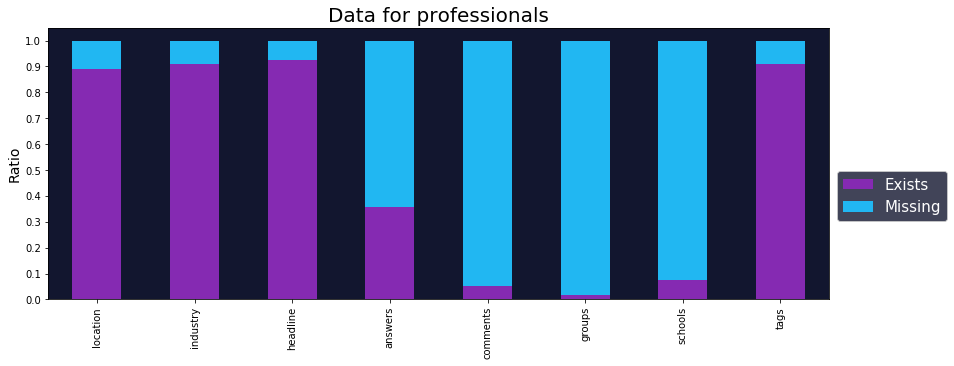

In [8]:

exists = 'Exists'
miss = 'Missing'

fields = {
    'students': {
        'df': students,
        'features': ['location'],
        'count': {
            'questions': questions,
            'comments': comments
        },
        'memberships': {
            'groups': group_memberships,
            'schools': school_memberships
        },
        'plts': {}
    },
    'professionals': {
        'df': professionals,
        'features': ['location', 'industry', 'headline'],
        'count': {
            'answers': answers,
            'comments': comments
        },
        'memberships': {
            'groups': group_memberships,
            'schools': school_memberships
        },
        'plts': {} 
    }
}

for user in fields.keys():
    user_spec = fields[user]
    
    df = user_spec['df']
    
    tmp = df[['{}_{}'.format(user, feature) for feature in user_spec['features']]]
    tmp = tmp.fillna(miss)
    tmp[tmp != miss] = exists 

    for feature in user_spec['features']:
        user_spec['plts'][feature] = tmp.groupby('{}_{}'.format(user, feature)).size()/len(tmp)
    
    # Counts
    for key, cdf in user_spec['count'].items():
        tf = cdf.groupby('{}_author_id'.format(key)).size()
        tf['counts'] = pd.merge(df, pd.DataFrame(tf.rename('count')), left_on='{}_id'.format(user), right_index=True, how='left')['count'].fillna(0).astype(int)
        
        tf = tf['counts']
        tf[tf > 0] = exists
        tf[tf != exists] = miss
        
        user_spec['plts'][key] = tf.groupby(tf.values).size()/len(tf)

    # Counts
    for key, mdf in user_spec['memberships'].items():
        unique_userid_with_membership = mdf['{}_memberships_user_id'.format(key[:-1])].unique()
        tf = pd.DataFrame()
        tf['val'] = df['{}_id'.format(user)]
        
        tf[tf['val'].isin(unique_userid_with_membership)] = exists
        tf[tf['val'] != exists] = miss

        user_spec['plts'][key] = tf.groupby('val').size()/len(tf)
        
    # Tags
    unique_user_ids_with_tags = tag_users['tag_users_user_id'].unique()
    tf = pd.DataFrame()
    tf['val'] = df['{}_id'.format(user)]
    
    tf[tf['val'].isin(unique_user_ids_with_tags)] = exists
    tf[tf['val'] != exists] = miss
    
    user_spec['plts']['tags'] = tf.groupby('val').size()/len(tf)
    plt_data = pd.DataFrame(user_spec['plts'])
    
    plt_data.T.plot(kind='bar', stacked=True, figsize=(14, 5), colors=('#852ab2', '#21b7f2'))
    plt.ylabel('Ratio', fontsize=14)
    plt.title('Data for {}'.format(user), fontsize=20)
    plt.yticks(np.arange(0, 1.05, 0.1))
    leg = plt.legend(bbox_to_anchor=(1, 0.5), fontsize=15)
    for text in leg.get_texts():
        plt.setp(text, color = 'w')
    plt.show()

### User locations
From the previous chart, we saw that both types of users highly use *location*.
As we will see later on, there is some *location* based correlation between students and professionals in terms of answered questions. Also, it's reasonable, because lot's of career questions are location dependent. 

It means that it would be beneficial to have some knowledge based on such features.

It's easy to define a matrix of similarities between questions based on its content: *text* and *tags*. It's even possible to define such matrix including *industry*. However, more useful would be also take into account *location* feature as well as a *headline*. So we did it in our model.

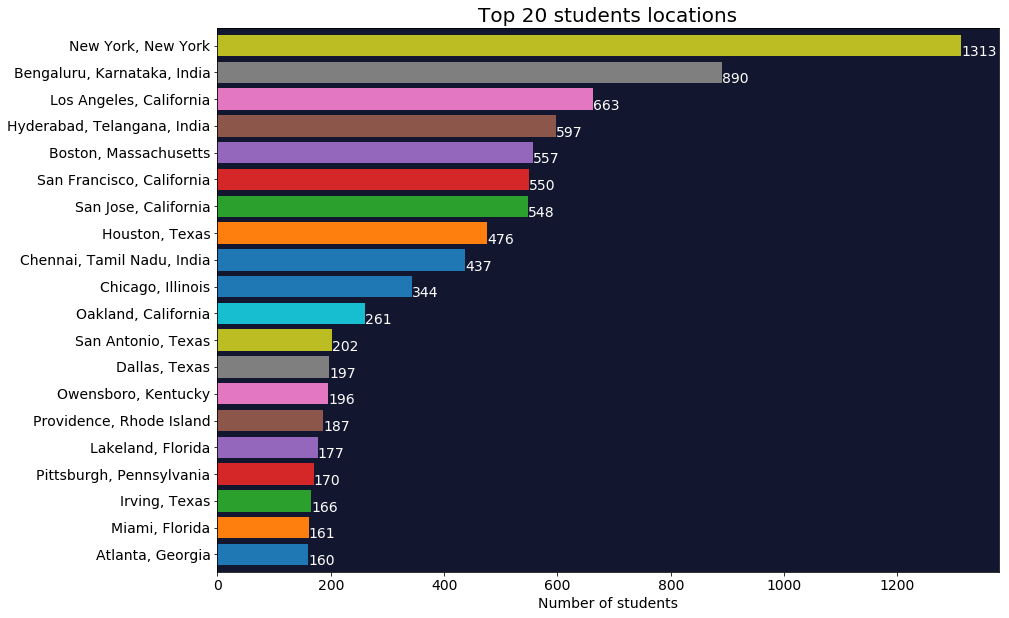

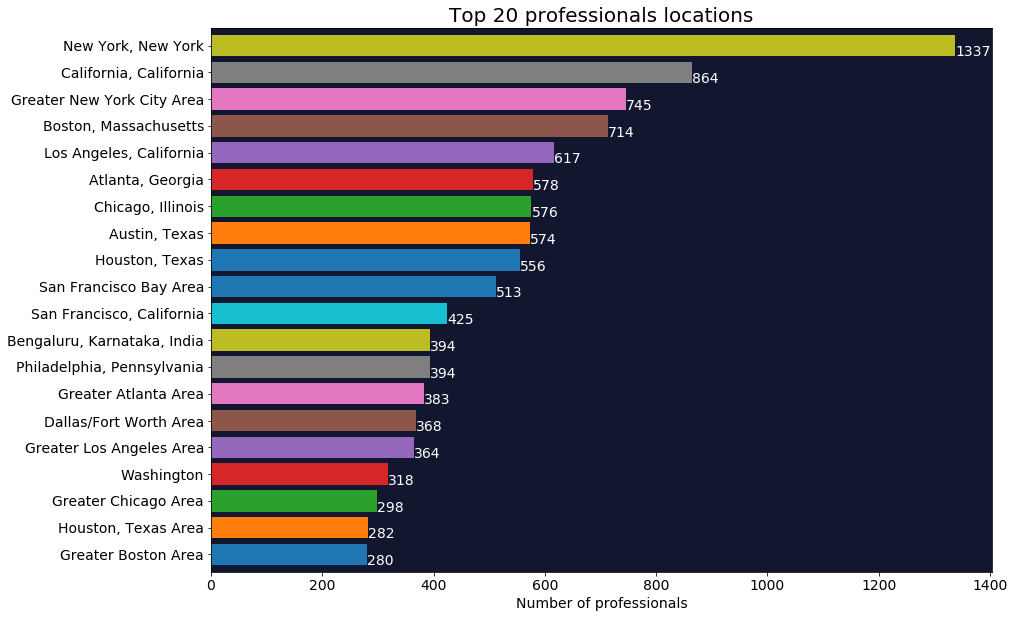

In [9]:
n_locations = 20

users = [
    ('students', students),
    ('professionals', professionals)
]

for user, df in users:
    locations = df['{}_location'.format(user)].value_counts().sort_values(ascending=True).tail(n_locations)
    
    ax = locations.plot(kind='barh',figsize=(14, 10),width=0.8, fontsize=14) 
    ax.set_title('Top %s {} locations'.format(user) % n_locations, fontsize=20)
    ax.set_xlabel('Number of {}'.format(user), fontsize=14)
    for p in ax.patches:
        ax.annotate(str(p.get_width()), (p.get_width(), p.get_y()), color='w', fontsize=14)
    plt.show()
    

### Users Growth Dynamics
This shows us that growth is stable which is suitable for improvement recommendations.

Current data is beneficial not only in terms of content for similarity matrix but also in terms of activity and interaction between users.

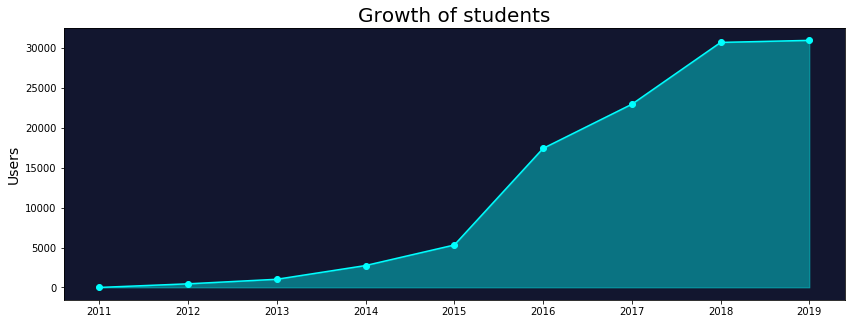

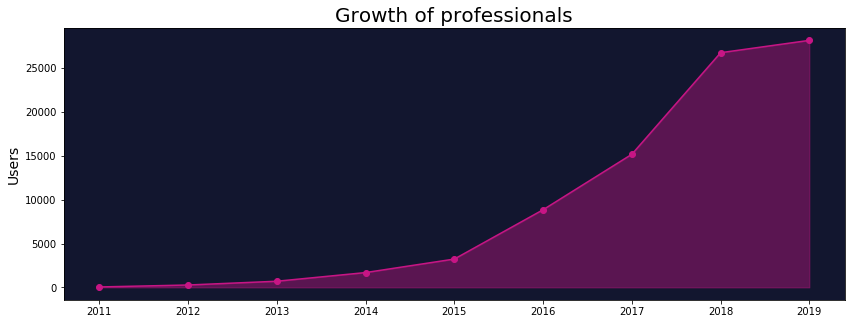

In [10]:
users = [
    ('students', students),
    ('professionals', professionals)
]

colors = {'students' : 'cyan', 'professionals' : 'mediumvioletred'}

for user, df in users:
    
    years = df['{}_date_joined'.format(user)].dt.year.unique()
    years.sort()
    
    min_date = df['{}_date_joined'.format(user)].min()
    min_date = min_date.strftime("%B %Y")
    
    max_date = df['{}_date_joined'.format(user)].max()
    max_date = max_date.strftime("%B %Y")
    
    
    amounts = [len(df[df['{}_date_joined'.format(user)].dt.year == y]) for y in years]
    
    for i in range(len(amounts)):
        if i > 0:
            amounts[i] += amounts[i - 1]
    to_plot = pd.DataFrame({'years': years, 'users': amounts})
    plt.figure(figsize=(14, 5))
    
    plt.plot('years', 'users', data=to_plot, marker='o', color=colors[user])
    x = to_plot['years']
    y = to_plot['users']
    plt.fill_between(x, y, color=colors[user], alpha = 0.4)
    
    plt.ylabel('Users', fontsize=14)
    plt.title('Growth of {}'.format(user), fontsize=20)
    plt.show()

### Number of Answers & Questions added per year
Here we can see the dynamics of the number of answers and questions per year. Questions amount correlates with yearly registration of students, so answers amount have the same pattern and grows too. However, it interesting what caused such a decrease in amounts during 2017.

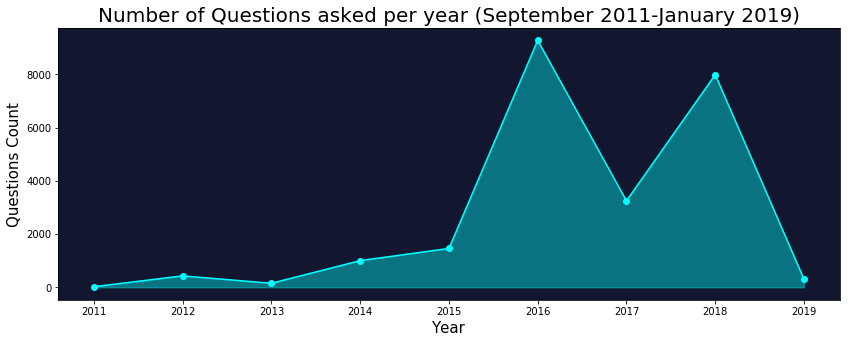

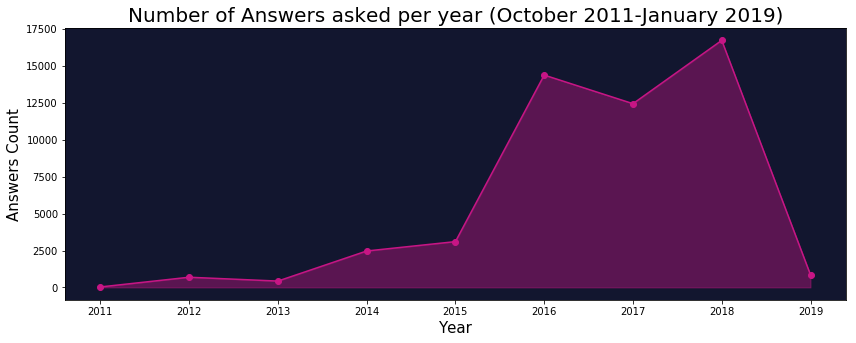

In [11]:
entities = [
    ('questions', questions),
    ('answers', answers)
]

colors = {'questions' : 'cyan', 'answers' : 'mediumvioletred'}

for entity, df in entities:
    min_date = df['{}_date_added'.format(entity)].min().strftime("%B %Y")
    max_date = df['{}_date_added'.format(entity)].max().strftime("%B %Y")

    df['year'] = df['{}_date_added'.format(entity)].dt.year
    plt_data = df.groupby('year').size()
    plt_data.plot(figsize=(14, 5), color=colors[entity],  marker='o')

    x = plt_data.reset_index()['year']
    y = plt_data.reset_index()[0]
    plt.fill_between(x, y, color=colors[entity], alpha = 0.4)

    plt.xlabel('Year', fontsize=15)
    plt.ylabel('{} Count'.format(entity.capitalize()), fontsize=15)
    plt.title('Number of {} asked per year ({}-{})'.format(entity.capitalize(), min_date, max_date), fontsize=20)
    plt.show()

### Professionals Answers & Students Questions amounts
Students are usually asking one or two questions.
Professionals are usually answering only one question. It can be caused by not sufficient feedback from students. Comment system and scores are used rarely.

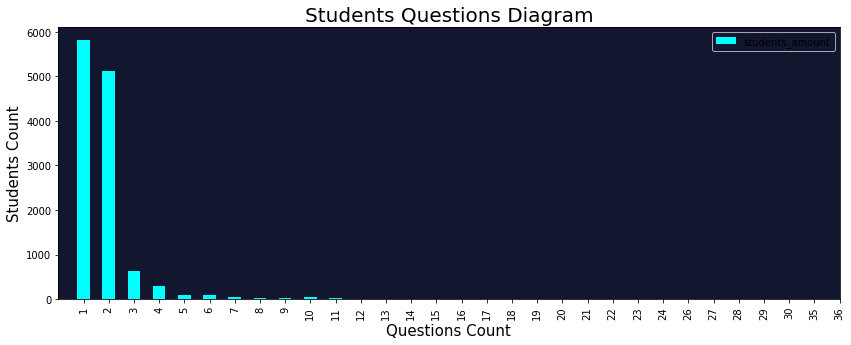

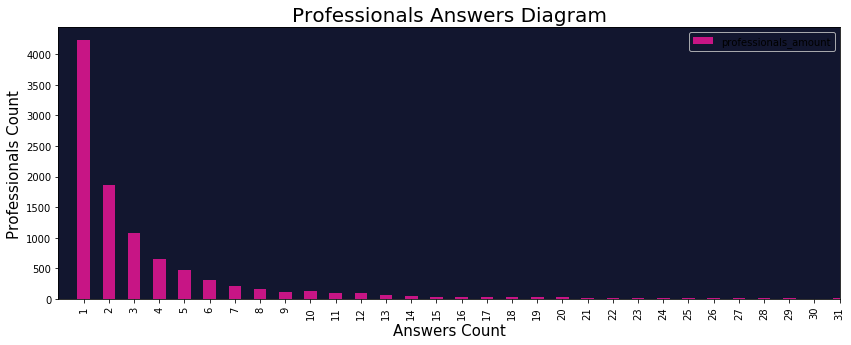

In [12]:
from collections import Counter 

ll = [
    ('students', 'questions', students, questions),
    ('professionals', 'answers', professionals, answers)
]

colors = {'students' : 'cyan', 'professionals' : 'mediumvioletred'}

for user, entity, user_df, entity_df in ll:
    tm = dict(sorted(Counter(pd.merge(user_df, entity_df, left_on='{}_id'.format(user), right_on='{}_author_id'.format(entity), how='inner').groupby('{}_id'.format(user)).size().values).items())) 
    t_d = {}
    t_d['{}_amount'.format(entity)] = list(tm.keys())
    t_d['{}_amount'.format(user)] = list(tm.values())

    plt_data = pd.DataFrame(t_d)

    plt_data.plot(x='{}_amount'.format(entity), y='{}_amount'.format(user), kind='bar', figsize=(14, 5), color=colors[user])
    plt.xlim(-1, 30)
    plt.xlabel('{} Count'.format(entity.capitalize()), fontsize=15)
    plt.ylabel('{} Count'.format(user.capitalize()), fontsize=15)
    plt.title('{} {} Diagram'.format(user.capitalize(), entity.capitalize()), fontsize=20)
    plt.show()


### Top n Professionals with most Answers & Students with most Questions
The distribution of students with the highest amount of questions is quite linear. 6 of these curious students asked more than 70 questions, and 4 students asked more than 40 questions.

The distribution of professionals with the highest amount of answers is fascinating. Some ultimate professionals answered more than a thousand questions - the platform contains 51123 answers, and those people added almost 12.5% of them (6344)! 

However, our task is to increase the number of answers to improve the system, so we need to focus on the professionals that drop off quickly.

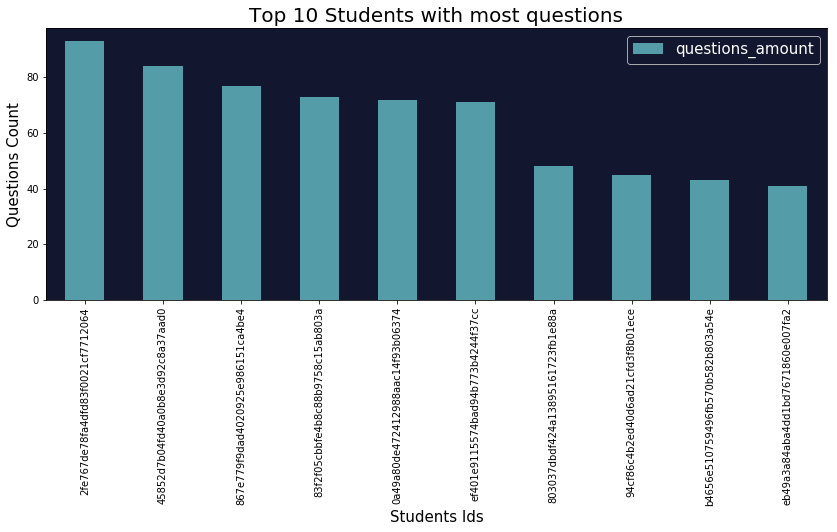

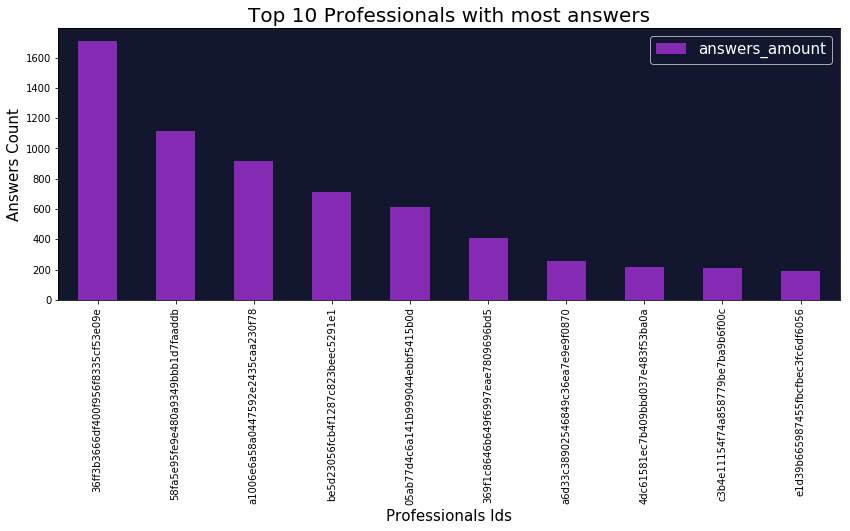

In [13]:
n = 10

ll = [
    ('students', 'questions', students, questions),
    ('professionals', 'answers', professionals, answers)
]

colors = {'students' : '#549da8', 'professionals' : '#852ab2'} 

for user, entity, user_df, entity_df in ll:
    top_n = pd.DataFrame(pd.merge(user_df, entity_df, left_on='{}_id'.format(user), right_on='{}_author_id'.format(entity), how='inner').groupby('{}_id'.format(user)).size().reset_index())
    plt_data = top_n.rename(index=str, columns={0: '{}_amount'.format(entity)}).sort_values(by=['{}_amount'.format(entity)], ascending=False)[:n]

    plt_data.plot(kind='bar', figsize=(14, 5), color=colors[user])
    plt.xticks(np.arange(len(plt_data)), tuple(plt_data['{}_id'.format(user)]), rotation=90)
    plt.xlabel('{} Ids'.format(user.capitalize()), fontsize=15)
    plt.ylabel('{} Count'.format(entity.capitalize()), fontsize=15)
    plt.title('Top {} {} with most {}'.format(n, user.capitalize(), entity), fontsize=20)
    leg = plt.legend(loc='best', fontsize=15)
    for text in leg.get_texts():
        plt.setp(text, color = 'w')
    plt.show()

### First activity after registration  <a id="eda_plots_fa"></a>
There are two general types of users:
- Activity right after registration
- No activity at all

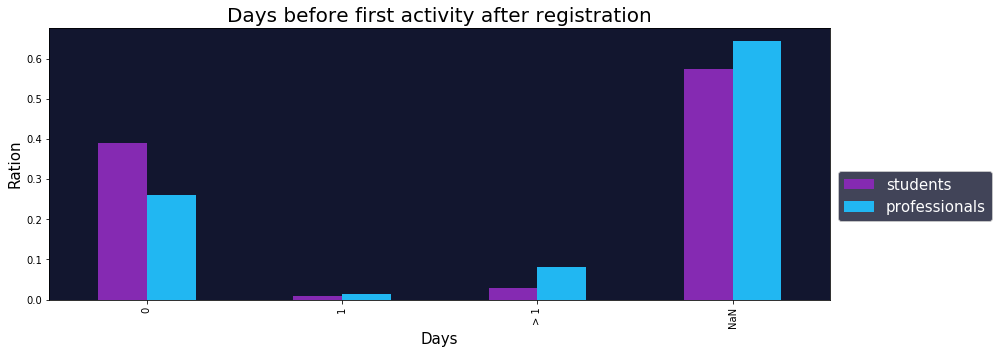

In [14]:
users = [
    ('students', students),
    ('professionals', professionals)
]

min_rel_date = '01-01-2016'
max_rel_date = '01-01-2019'

plt_data = {}

for user, df in users:
    df = df[(df['{}_date_joined'.format(user)] >= min_rel_date) & (df['{}_date_joined'.format(user)] <= max_rel_date)]
    df = (df['date_first_activity'] - df['{}_date_joined'.format(user)]).dt.days.fillna(10000).astype(int)
    df = df.groupby(df).size()/len(df)
    df = df.rename(lambda x: 0 if x < 0 else x)
    df = df.rename(lambda x: x if x <= 1 or x == 10000 else '> 1')
    df = df.rename({10000: 'NaN'})
    df = df.groupby(level=0).sum()

    plt_data[user] = df

plt_data = pd.DataFrame(plt_data)

plt_data.plot(kind='bar', figsize=(14, 5), colors=('#852ab2', '#21b7f2'))
plt.xlabel('Days', fontsize=15)
plt.ylabel('Ration', fontsize=15)
plt.title('Days before first activity after registration', fontsize=20)
leg = plt.legend(bbox_to_anchor=(1, 0.5), fontsize=15)
for text in leg.get_texts():
    plt.setp(text, color = 'w')
plt.show()

### Last activity  <a id="eda_plots_la"></a>  
Depending on the last comment, question or answer of a user, we have extracted the last activity date. On the previous plot we have seen, that many users haven't done any activity yet. For the 'last activity' plot we take a look only on users with already have one activity (*dropna*).  

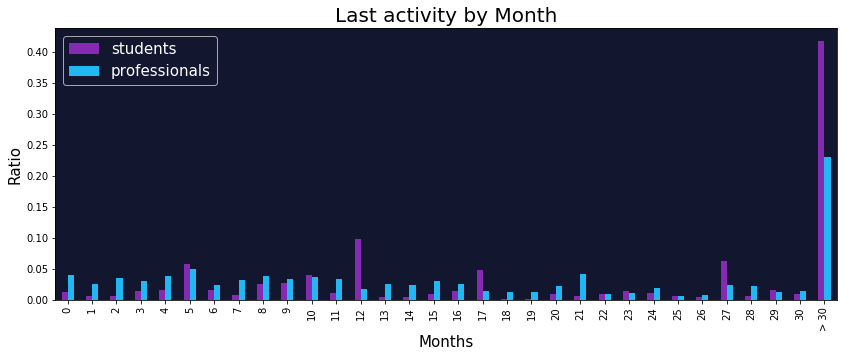

In [15]:
# Date of export
current_date = datetime(2019, 2 ,1)

users = [
    ('students', students),
    ('professionals', professionals)
]

plt_data = {}

for user, df in users:
    df = ((current_date - df['date_last_activity']).dt.days/30).dropna().astype(int)
    df = df.groupby(df).size()/len(df)
    df = df.rename(lambda x: 0 if x < 0 else x).rename(lambda x: x if x <= 30 or x == 10000 else '> 30').rename({10000:'NaN'})
    df = df.groupby(level=0).sum()

    plt_data[user] = df

plt_data = pd.DataFrame(plt_data)

plt_data.plot(kind='bar', figsize=(14, 5), colors=('#852ab2', '#21b7f2'))
plt.xlabel('Months', fontsize=15)
plt.ylabel('Ratio', fontsize=15)
plt.title('Last activity by Month', fontsize=20)
leg = plt.legend(loc='best', fontsize=15)
for text in leg.get_texts():
    plt.setp(text, color = 'w')
plt.show()

### Days for first answer <a id="eda_plots_fa"></a>
As we can see most of the questions receive answers on the same day, which is good, but obviously, we want to make the ration higher for this first day.   
Also, it seems that interest in answering questions drops off quickly. Over 30% of answers are provided on the first day of involvement in CV.

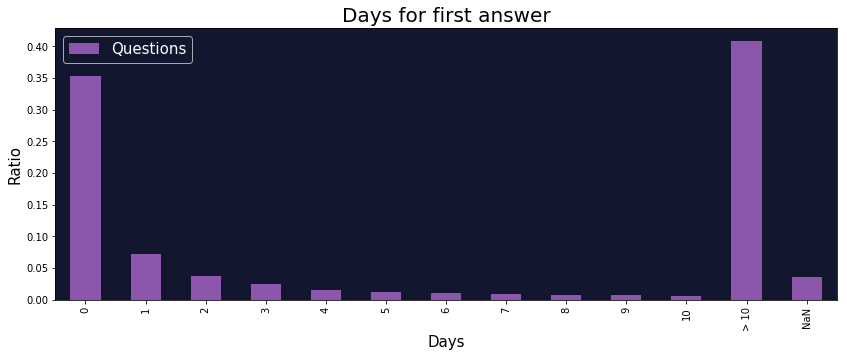

In [16]:
df = questions

min_rel_date = '01-01-2016'
max_rel_date = '01-01-2019'

tmp = answers[['answers_question_id', 'answers_date_added']].groupby('answers_question_id').min()
df['questions_first_answers'] = pd.merge(questions, pd.DataFrame(tmp), left_on='questions_id', right_index=True, how='left')['answers_date_added']

df = df[(df['questions_date_added'] >= min_rel_date) & (df['questions_date_added'] <= max_rel_date)]
df = ((df['questions_first_answers'] - df['questions_date_added']).dt.days).fillna(10000).astype(int)
df = df.groupby(df).size()/len(df.index)
df = df.rename(lambda x: 0 if x < 0 else x)
df = df.rename(lambda x: x if x <= 10 or x == 10000 else '> 10')
df = df.rename({10000:'NaN'})
df = df.groupby(level=0).sum()

plt_data = pd.DataFrame({'Questions': df})

plt_data.plot(kind='bar', figsize=(14, 5), color='#8d56ad')
plt.xlabel('Days', fontsize=15)
plt.ylabel('Ratio', fontsize=15)
plt.title('Days for first answer', fontsize=20)
leg = plt.legend(loc='best', fontsize=15)
for text in leg.get_texts():
    plt.setp(text, color = 'w')
plt.show()

### Mean response time per year
Here we can see the evolution of mean response time, which is a significant mark that shows the mean speed of answering questions. The dynamics show decreasing average time to response which changed from ~790 days to ~5.

The answer to the question indicates that the question is appropriate, but we should not rely on very long-time answers. So we need to pay more attention to the early stages of the relationship with the professional.

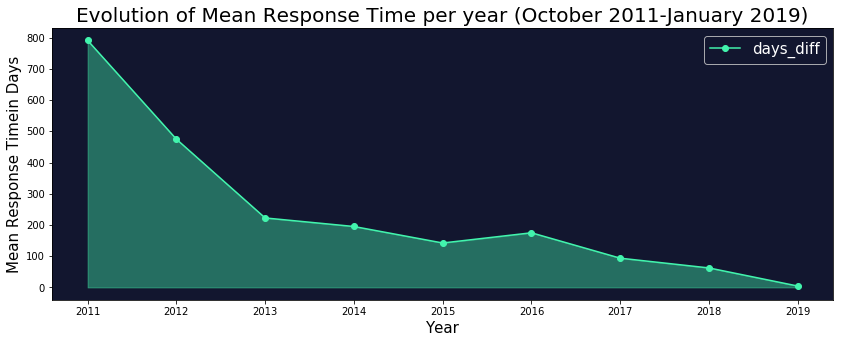

In [17]:
a_q = pd.merge(answers, questions, how='right', left_on='answers_question_id', right_on='questions_id')
a_q['days_diff'] = (a_q['answers_date_added'] - a_q['questions_date_added']).dt.days
plt_data = a_q[['year_y', 'days_diff']].groupby('year_y').mean()
plt_data.plot(figsize=(14, 5), color='#42f4ad',  marker='o')

x = plt_data.reset_index()['year_y']
y = plt_data.reset_index()['days_diff']
plt.fill_between(x, y, color='#42f4ad', alpha = 0.4)

plt.xlabel('Year', fontsize=15)
plt.ylabel('Mean Response Timein Days', fontsize=15)
plt.title('Evolution of Mean Response Time per year ({0}-{1})'.format(min_date, max_date), fontsize=20)
leg = plt.legend(loc='best', fontsize=15)
for text in leg.get_texts():
    plt.setp(text, color = 'w')
plt.show()

### Number of Emails sent per year
The number of emails sent yearly tends to grow each year.

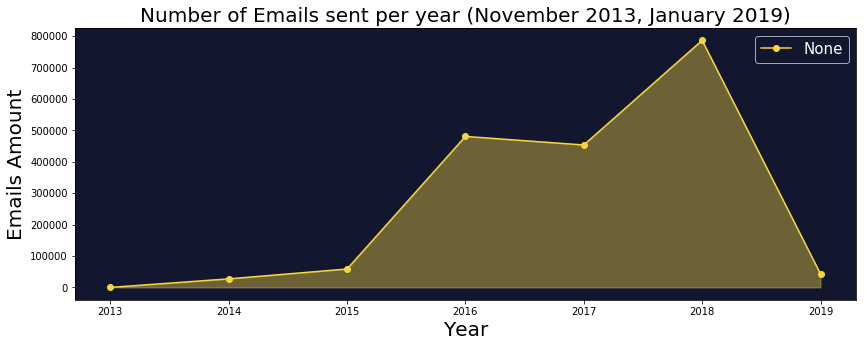

In [18]:
min_date = emails['emails_date_sent'].min().strftime("%B %Y")
max_date = emails['emails_date_sent'].max().strftime("%B %Y")

emails['year'] = emails['emails_date_sent'].dt.year
plt_data = emails.groupby('year').size()

plt_data.plot(figsize=(14, 5), color='#f4d641',  marker='o')

x = plt_data.reset_index()['year']
y = plt_data.reset_index()[0]
plt.fill_between(x, y, color='#f4d641', alpha = 0.4)

plt.xlabel('Year', fontsize=20)
plt.ylabel('Emails Amount', fontsize=20)
plt.title('Number of Emails sent per year ({0}, {1})'.format(min_date, max_date), fontsize=20)
leg = plt.legend(loc='best', fontsize=15)
for text in leg.get_texts():
    plt.setp(text, color = 'w')
plt.show()

### How many questions are contained in each email
Most emails contain 1-3 questions, so an average amount of questions per email is 2.33.

Accessing questions is also possible directly from the Career Village website, so professionals are not restricted to answering emails, so contact method should not be assumed. However, we need inferred links between questions and professionals to build a recommender.

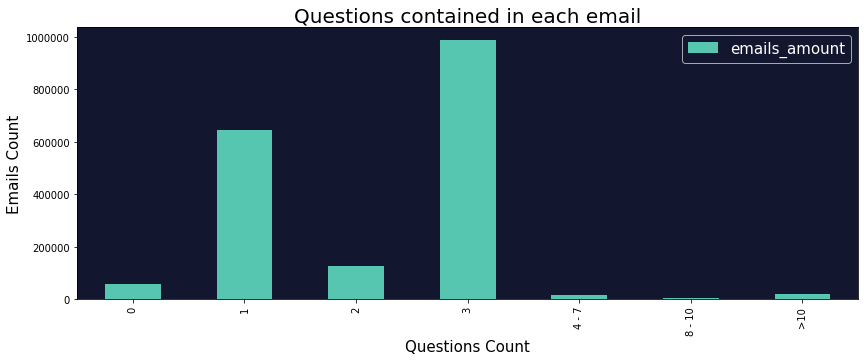

In [19]:
e_m = pd.DataFrame(pd.merge(emails, matches, how='inner', left_on='emails_id', right_on='matches_email_id').groupby('emails_id').size().reset_index()).rename(index=str, columns={0: "questions_amount"}).sort_values(by=['questions_amount'], ascending=False)
plt_data = e_m.groupby('questions_amount').size().reset_index().rename(index=str, columns={0: "emails_amount"})

mapping = {
    1: '1',
    2: '2',
    3: '3',
    4: '4 - 7',
    8: '8 - 10',
}

def get_key(x):
    for i in range(x, 0, -1):
        if i in mapping:
            return mapping[i]


plt_data['groups'] = plt_data['questions_amount'].apply(lambda x: '>10' if x >= 11 else get_key(x))
plt_data = pd.DataFrame({'groups' :['0'], 'emails_amount' : [len(emails) - len(e_m)]}).append(plt_data.groupby('groups').sum().reset_index()[['groups', 'emails_amount']])

plt_data.plot(kind='bar', figsize=(14, 5), color='#57c6b1')

plt.xticks(np.arange(len(plt_data)), tuple(plt_data['groups']))
plt.xlabel('Questions Count', fontsize=15)
plt.ylabel('Emails Count', fontsize=15)
plt.title('Questions contained in each email', fontsize=20)
leg = plt.legend(loc='best', fontsize=15)
for text in leg.get_texts():
    plt.setp(text, color = 'w')
plt.show()

### Tags Wordclouds <a id="eda_plots_tm"></a> 
In most of the cases, students are not using tags. Student tags are similar to questions tags. The current system is recommending questions tags, and they are not that similar to those which professionals are following. 

Tags of questions and students and more generalized comparing to professionals tags. It means that even if we apply some processing and modeling techniques and deriving similarities out of it, there still be unmatched student and professionals using tags due to **generalized** vs. **specialized** tags problem.

Our model also solves this issue.

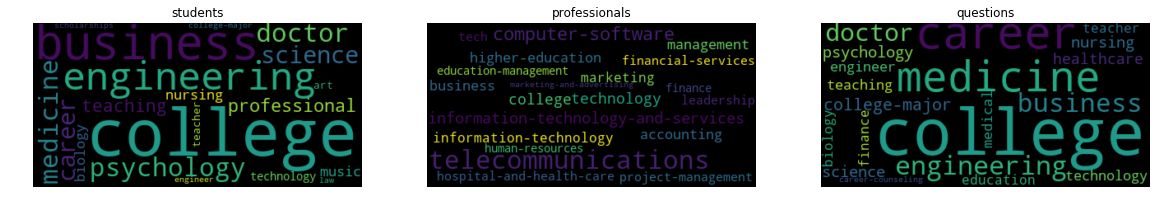

In [20]:
entities = [
    ('students', students),
    ('professionals', professionals),
    ('questions', questions)
]

dfs = []

for entity, df in entities:
    if entity == 'questions':
        df = tag_questions
        df = pd.merge(df, tags, left_on='tag_questions_tag_id', right_on='tags_tag_id')
    else:
        df = tag_users[tag_users['tag_users_user_id'].isin(df['{}_id'.format(entity)])]
        df = pd.merge(df, tags, left_on='tag_users_tag_id', right_on='tags_tag_id')

    df['entity_type'] = entity

    dfs.append(df)


plt_data = pd.concat(dfs)


plt_data = plt_data[['tags_tag_name', 'entity_type']].pivot_table(index='tags_tag_name', columns='entity_type', aggfunc=len, fill_value=0)

for entity, df in entities:
    plt_data[entity] = plt_data[entity] / len(df)

plt_data['sum'] = (plt_data['professionals'] + plt_data['students'] + plt_data['questions'])
plt_data = plt_data.sort_values(by='sum', ascending=False).drop(['sum'], axis=1).head(100)


# Wordcloud
plt.figure(figsize=(20, 20))
wordloud_values = ['students', 'professionals', 'questions']
axisNum = 1
for wordcloud_value in wordloud_values:
    wordcloud = WordCloud(margin=0, max_words=20, random_state=42).generate_from_frequencies(plt_data[wordcloud_value])
    ax = plt.subplot(1, 3, axisNum)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(wordcloud_value)
    plt.axis("off")
    axisNum += 1
plt.show()    

## 5. NLP <a id="nlp"></a>

Textual data is the main form of information in the provided dataset. To utilize it numerically, first, we apply some generic text preprocessing. We remove stopwords and HTML tags, cast everything to lower case and stem each word. NLTK and regular expressions come to rescue here.

All the text processing stuff is implemented in TextProcessor class

In [21]:
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

class TextProcessor:
    """
    Class for carrying all the text pre-processing stuff throughout the project
    """

    def __init__(self):
        self.stopwords = stopwords.words('english')
        self.ps = PorterStemmer()

        # stemmer will be used for each unique word once
        self.stemmed = dict()

    def process(self, text: str, allow_stopwords: bool = False) -> str:
        """
        Process the specified text,
        splitting by non-alphabetic symbols, casting to lower case,
        removing stopwords, HTML tags and stemming each word

        :param text: text to precess
        :param allow_stopwords: whether to remove stopwords
        :return: processed text
        """
        ret = []

        # split and cast to lower case
        text = re.sub(r'<[^>]+>', ' ', str(text))
        for word in re.split('[^a-zA-Z]', str(text).lower()):
            # remove non-alphabetic and stop words
            if (word.isalpha() and word not in self.stopwords) or allow_stopwords:
                if word not in self.stemmed:
                    self.stemmed[word] = self.ps.stem(word)
                # use stemmed version of word
                ret.append(self.stemmed[word])
        return ' '.join(ret)

In [22]:

tp = TextProcessor()

To objectively measure the performance of our recommendation engine, we split data into train and test subsets right here. Train subset of data will consist of each dataframe split by datetime-like column with values before SPLIT_DATE. Thus, we are sure no data after SPLIT_DATE will make it to train 

In [23]:
answers['answers_body'] = answers['answers_body'].apply(tp.process)
ans_train = answers[answers['answers_date_added'] < SPLIT_DATE]

questions['questions_title'] = questions['questions_title'].apply(tp.process)
questions['questions_body'] = questions['questions_body'].apply(tp.process)
questions['questions_whole'] = questions['questions_title'] + ' ' + questions['questions_body']
que_train = questions[questions['questions_date_added'] < SPLIT_DATE]

professionals['professionals_headline'] = professionals['professionals_headline'].apply(tp.process)
professionals['professionals_industry'] = professionals['professionals_industry'].apply(tp.process)
pro_train = professionals[professionals['professionals_date_joined'] < SPLIT_DATE]

stu_train = students[students['students_date_joined'] < SPLIT_DATE]

tags['tags_tag_name'] = tags['tags_tag_name'].apply(lambda x: tp.process(x, allow_stopwords=True))

tag_que = tag_questions.merge(tags, left_on='tag_questions_tag_id', right_on='tags_tag_id')
tag_pro = tag_users.merge(tags, left_on='tag_users_tag_id', right_on='tags_tag_id')

### Doc2Vec <a id="nlp_doc2vec"></a>

The first tool we use to extract features from text is doc2vec algorithm.  
Doc2Vec is a development of well-known Word2Vec algorithm used for unsupervised training of word embeddings on large text corpora. The difference is that Doc2Vec adds simultaneous training not only for words but also for tags associated with documents. If the tags are unique than we achieve descriptive high-dimensional vectors of each document. If the tag appears in pair with many documents, then its embedding contains information about all the words associated documents consist of.  
We use Doc2Vec in both of named modes. Via the first mode, we obtain individual question's embeddings based on its title and body, and thanks to the properties of the algorithm, we are able to compute these vectors for new data.  
Via the second mode, we obtain embeddings for question's tags and professional's industries. We will use all of the textual data available for that purpose:
- Question's title
- Question's body
- Answer's body
- Question's tags names
- Professional's tags names
- Professional's industries
- Professional's headlines 

We use Doc2Vec implementation from Gensim, an excellent toolkit for topic modeling

#### Training

Doc2Vec training pipeline is implemented in train_d2v() and pipeline_d2v() functions

In [24]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

def train_d2v(df: pd.DataFrame, target: str, features: list, dim: int) -> (Doc2Vec, dict):
    """
    Train Doc2Vec object on provided data
    :param df: data to work with
    :param target: column name of target entity in df to train embeddings for
    :param features: list of feature names to be used for training
    :param dim: dimension of embedding vectors to train
    :return: trained Doc2Vec object
    """
    prepared = []
    for feature in features:
        if feature != target:
            prepared += [TaggedDocument(row[feature].split(), [row[target]])
                         for i, row in df[[feature, target]].drop_duplicates().iterrows()]
        else:
            prepared += [TaggedDocument(s.split(), [s]) for s in df[target].drop_duplicates()]
    # shuffle prepared data, just in case
    prepared = random.sample(prepared, len(prepared))
    d2v = Doc2Vec(prepared, vector_size=dim, workers=4, epochs=10, dm=0)
    docvecs = {d2v.docvecs.index2entity[i]: d2v.docvecs.vectors_docs[i]
               for i in range(len(d2v.docvecs.index2entity))}
    return d2v, docvecs


def pipeline_d2v(que: pd.DataFrame, ans: pd.DataFrame, pro: pd.DataFrame, tag_que: pd.DataFrame, tag_pro: pd.DataFrame,
                 dim: int) -> (dict, dict, Doc2Vec):
    """
    Pipeline for training embeddings for
    professional's industries and question's tags via doc2vec algorithm
    on question titles, bodies, answer bodies, names of tags, professional industries and headlines

    :param que: raw questions.csv dataset
    :param ans: raw answers.csv dataset
    :param pro: raw professionals.csv dataset
    :param tag_que: tags.csv merged with tag_questions.csv
    :param tag_pro: tags.csv merged with tag_users.csv
    :param dim: dimension of doc2vec embeddings to train
    :return: trained tags, industries embeddings and question's Doc2Vec model
    """
    # aggregate all the tags in one string for same professionals
    pro_tags = tag_pro[['tag_users_user_id', 'tags_tag_name']].groupby(by='tag_users_user_id', as_index=False) \
        .aggregate(lambda x: ' '.join(x)).rename(columns={'tags_tag_name': 'tags_pro_name'})
    pro_tags = pro.merge(pro_tags, left_on='professionals_id', right_on='tag_users_user_id')

    # merge questions, tags, answers and professionals
    que_tags = que.merge(tag_que, left_on='questions_id', right_on='tag_questions_question_id')
    ans_que_tags = ans.merge(que_tags, left_on="answers_question_id", right_on="questions_id")
    df = ans_que_tags.merge(pro_tags, left_on='answers_author_id', right_on='professionals_id')

    text_features = ['questions_title', 'questions_body', 'answers_body', 'tags_tag_name', 'tags_pro_name',
                     'professionals_industry', 'professionals_headline']

    # train and save question's tags embeddings
    _, tags_embs = train_d2v(df, 'tags_tag_name', text_features, dim)

    # aggregate all the tags in one string for same questions
    que_tags = que_tags[['questions_id', 'tags_tag_name']].groupby(by='questions_id', as_index=False) \
        .aggregate(lambda x: ' '.join(x))

    # merge questions, aggregated tags, answers and professionals
    que_tags = que.merge(que_tags, on='questions_id')
    ans_que_tags = ans.merge(que_tags, left_on="answers_question_id", right_on="questions_id")
    df = ans_que_tags.merge(pro_tags, left_on='answers_author_id', right_on='professionals_id')

    # train and save professional's industries embeddings
    _, inds_embs = train_d2v(df, 'professionals_industry', text_features, dim)

    head_d2v, _ = train_d2v(df, 'professionals_headline', text_features, 5)

    ques_d2v, _ = train_d2v(que_tags, 'questions_id', ['questions_whole'], dim)

    return tags_embs, inds_embs, head_d2v, ques_d2v

In [25]:
n_emb = 10
tag_embs, ind_embs, head_d2v, ques_d2v = pipeline_d2v(que_train, ans_train, pro_train, tag_que, tag_pro, n_emb)

#### Visualization

In [26]:
from sklearn.manifold import TSNE

def vis_emb(id_to_vec: dict, occurrences: pd.Series, title: str):
    """
    Visualize embeddings via T-SNE
    """
    top = set(occurrences.value_counts().iloc[:100].index)
    filtered = {key: value for key, value in id_to_vec.items() if key in top}
    
    proj = TSNE(n_components=2).fit_transform(np.vstack(filtered.values()))
    
    _, ax = plt.subplots(figsize=(12, 12))
    plt.scatter(proj[:, 0], proj[:, 1], alpha=0.7, s=90, c='#69f0ff')
    for i, name in enumerate(filtered.keys()):
        ax.annotate(name, (proj[i, 0], proj[i, 1]), color='w')
        
    ax.set_title(title, fontsize=20)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    plt.show()

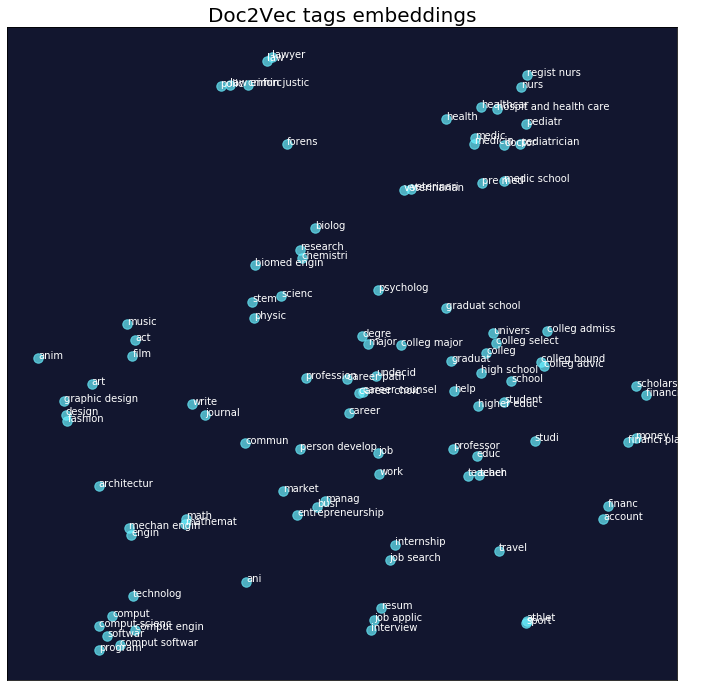

In [27]:
vis_emb(tag_embs, tag_que['tags_tag_name'], 'Doc2Vec tags embeddings')

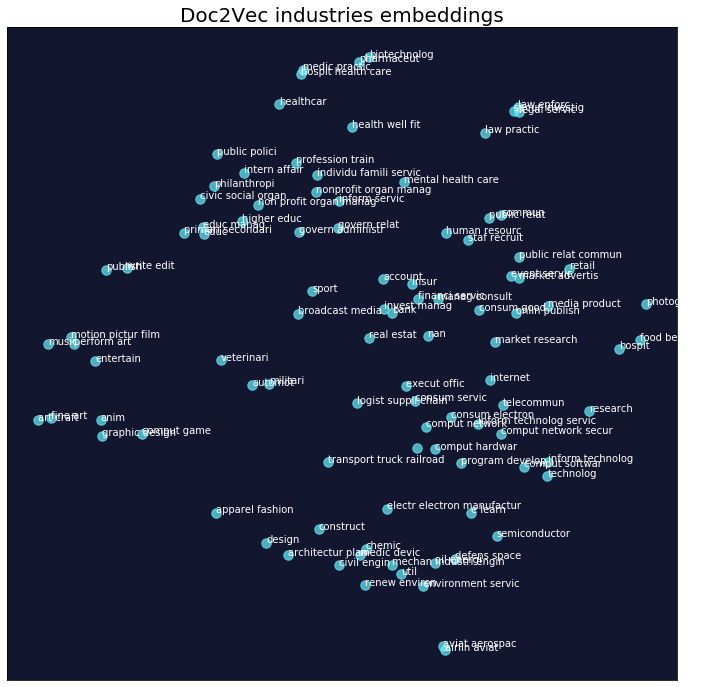

In [28]:
vis_emb(ind_embs, pro_train['professionals_industry'], 'Doc2Vec industries embeddings')

### LDA <a id="nlp_lda"></a> 

The main reason to use Latent Dirichlet Allocation is uncovering the themes lurking in the text data. By using LDA on pizza orders, it is possible to infer pizza topping themes like spicy, salty, savory, and sweet. It can be used to extract the topics distribution across the questions and words characterize corresponding topics.

As a result, each question is represented as a vector of fixed length, which is easy to use for similarity measures. 

In order to perform LDA on question's text data, we need to:
- Filter the text data and anomalies
- Calculate the TF-IDF
- Train LDA Model

#### Training
LDA training pipeline is implemented in pipeline_lda() function

In [29]:
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim.models.ldamulticore import LdaMulticore

def pipeline_lda(que: pd.DataFrame, dim: int) -> (Dictionary, TfidfModel, LdaMulticore):
    """
    Pipeline for training embeddings for questions via LDA algorithm
    on question titles and bodies

    :param que: raw questions.csv dataset
    :param dim: dimension of doc2vec embeddings to train
    :return: trained tags, industries embeddings and question's Doc2Vec model
    """
    lda_tokens = que['questions_whole'].apply(lambda x: x.split())

    # create Dictionary and train it on text corpus
    lda_dic = Dictionary(lda_tokens)
    lda_dic.filter_extremes(no_below=10, no_above=0.6, keep_n=8000)
    lda_corpus = [lda_dic.doc2bow(doc) for doc in lda_tokens]

    # create TfidfModel and train it on text corpus 
    lda_tfidf = TfidfModel(lda_corpus)
    lda_corpus = lda_tfidf[lda_corpus]

    # create LDA Model and train it on text corpus
    lda_model = LdaMulticore(
        lda_corpus, num_topics=dim, id2word=lda_dic, workers=4,
        passes=20, chunksize=1000, random_state=0
    )

    return lda_dic, lda_tfidf, lda_model

Number of topics is selected manually. Empirically we derived, that the dimensionality should be set to 10. Higher dimensionality doesn't give us an increase in accuracy. It's also good to have the same amount of features from each NLP model to compare their importance in general.

In [30]:
lda_dic, lda_tfidf, lda_model = pipeline_lda(que_train, n_emb)

#### Visualization
For visualization purposes it's better to have more topics to get the better filling of what's going on.

TextPreprocessor stems tags, so it cuts words a bit.

In [31]:
def plot_lda_wordcloud(lda_model, rows, columns):
    """
    Word Cloud for each topic of the LDA model
    """  
    n_ax = 0
    plt.figure(figsize=(5*columns, 2*rows))
    for t_id in range(lda_model.state.get_lambda().shape[0]):
        #gather most relevant terms for the given topic
        topics_terms = lda_model.state.get_lambda()
        tmp = {}
        for i in range(1, len(topics_terms[0])):
            tmp[lda_model.id2word[i]]=topics_terms[t_id,i]

        # wordcloud drawing
        wordcloud = WordCloud(margin=0, max_words=15).generate_from_frequencies(tmp)
        n_ax += 1
        ax = plt.subplot(rows, columns, n_ax)

        plt.imshow(wordcloud, interpolation='bilinear')
        title = t_id
        plt.title(title)
        plt.axis("off")
        plt.margins(x=0, y=0)

    plt.show()

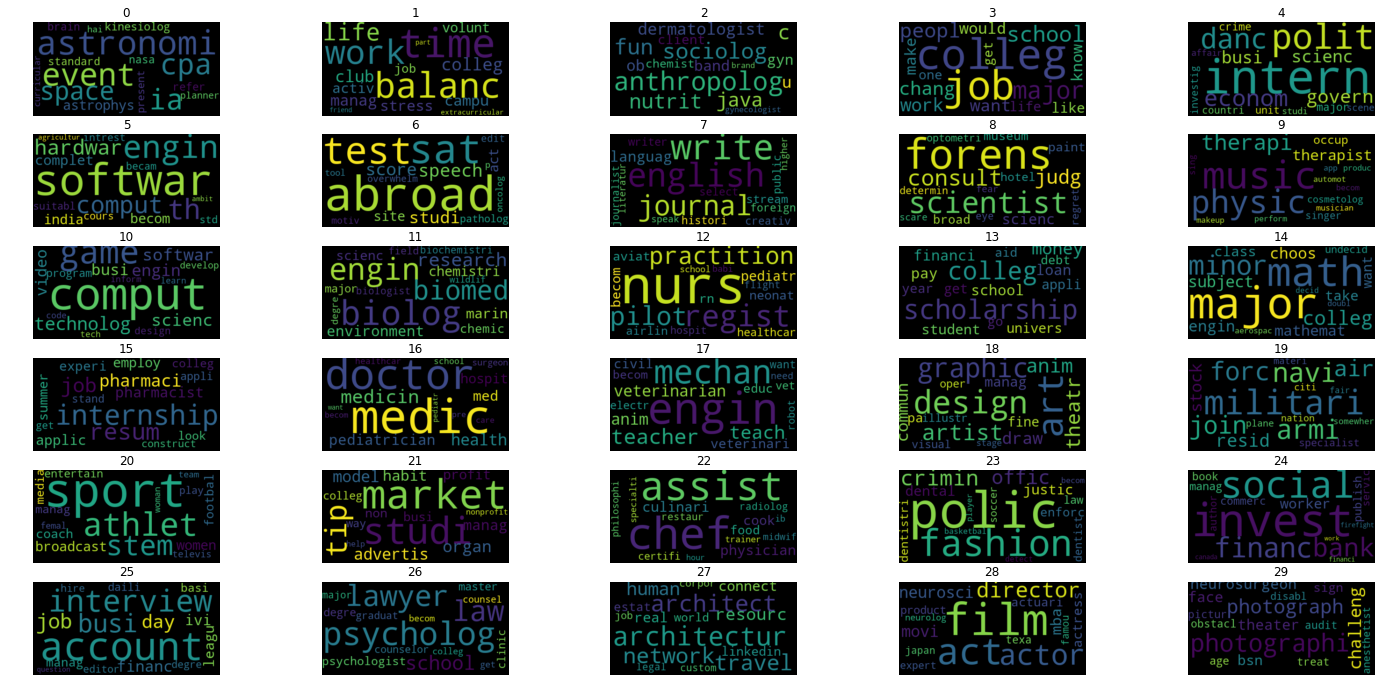

In [32]:
_, _, lda_for_vis_model = pipeline_lda(que_train, 30)
plot_lda_wordcloud(lda_for_vis_model, 6, 5)

## 6. Feature Engineering <a id="feature_engineering"></a>

There are three main entities in our dataset for which we compute features separately: questions, students and professionals. Later in pipeline, when passing data to model, student's features are combined with question's to obtain complete question's feature vector.  
The reason for splitting question's features into two parts is the design principle in which question's features need to be time-independent, while student's feature vector, just like the professional's one, inevitably change in time.  
Thus, for proper forming of train data, we need to compute for each moment features of student and professional change. These moments will corresponds to appearances of new answers.

#### Base feature preprocessing class

We distinguish three main types of features: categorical, numerical and datetime-like
- For categorical features, we consider only top N of its most popular categories. We encode them via LabelEncoder with labels from 0 to N-1; all the remaining categories encoded with N and NaNs with N+1 label. Later, in the model we train embeddings for every label of each categorical feature
- In a numerical feature, we fill its NaNs with either zero or mean and then standardize it via StandardScaler
- From the datetime-like feature we extract three new features: absolute time, sine and cosine of the scaled day of the year. Then, we work with three new features just like with numerical ones

All this basic feature preprocessing logic is implemented in abstract base class BaseProc. Classes with the implementation of feature engineering unique for each of three entities (question, student, professional) are inherited from BaseProc.

In [33]:
from abc import ABC
from sklearn.preprocessing import StandardScaler, LabelEncoder

class BaseProc(ABC):
    """
    Class with implementation of basic preprocessors logic
    """

    def __init__(self):
        self.pp = {}
        self.features = {
            'categorical': [],
            'numerical': {'zero': [], 'mean': []},
            'date': []
        }

    def _unroll_features(self):
        """
        Called once after self.features specification in constructor of child class,
        unrolls all the features in single separate list self.features['all']
        """
        self.features['all'] = ([name for name, deg in self.features['categorical']]
                                if 'categorical' in self.features else []) + \
                               (self.features['numerical']['zero'] + self.features['numerical']['mean']
                                if 'numerical' in self.features else []) + \
                               ([f + p for f in self.features['date']
                                 for p in ['_time', '_doy_sin', '_doy_cos']]
                                if 'date' in self.features else [])

    def datetime(self, df: pd.DataFrame, feature: str):
        """
        Generates a bunch of new datetime features and drops the original feature inplace

        :param df: data to work with
        :param feature: name of a column in df that contains date
        """
        # iterate over suffix of generated features and function to calculate it
        for suf, fun in [('_time', lambda d: d.year + (d.dayofyear + d.hour / 24) / 365),
                         ('_doy_sin', lambda d: np.sin(2 * np.pi * d.dayofyear / 365)),
                         ('_doy_cos', lambda d: np.cos(2 * np.pi * d.dayofyear / 365))]:
            df[feature + suf] = df[feature].apply(fun)
            # add created feature to the list of generated features
            self.features['gen'].append(feature + suf)

        df.drop(columns=feature, inplace=True)

    def __get_preprocessor(self, fit_data: np.array, feature: str, base):
        """
        Creates new preprocessor object of class base and fits it
        or uses existing one in self.pp and returns it

        :param fit_data: NumPy array of data to fit new preprocessor
        :param feature: feature name to search for in self.pp
        :param base: new preprocessor's class
        :returns: preprocessor object
        """
        if feature in self.pp:
            preproc = self.pp[feature]
        else:
            preproc = base()
            preproc.fit(fit_data)
            self.pp[feature] = preproc
        return preproc

    def numerical(self, df: pd.DataFrame, feature: str, fillmode: str):
        """
        Transforms via StandardScaler, fills NaNs according to fillmode

        :param df: data to work with
        :param feature: name of a column in df that contains numerical data
        :param fillmode: method to fill NaNs, either 'mean' or 'zero'
        """
        # calculate default value and fill NaNs with it
        if fillmode == 'mean':
            if feature in self.pp:
                na = self.pp[feature].mean_[0]
            else:
                na = df[feature].mean()
        else:
            na = 0

        df[feature].fillna(na, inplace=True)

        # standardize feature values
        fit_data = df[feature].values.reshape(-1, 1).astype('float64')
        sc = self.__get_preprocessor(fit_data, feature, StandardScaler)
        df[feature] = sc.transform(fit_data)

    def categorical(self, df: pd.DataFrame, feature: str, n: int):
        """
        Encodes top n most popular values with different labels from 0 to n-1,
        remaining values with n and NaNs with n+1

        :param df: data to work with
        :param feature: name of a column in df that contains categorical data
        :param n: number of top by popularity values to move in separate categories.
                  0 to encode everything with different labels
        """
        vc = df[feature].value_counts()
        # number of unique values to leave
        n = len(vc) if n == 0 else n
        # unique values to leave
        top = set(vc[:n].index)
        isin_top = df[feature].isin(top)

        fit_data = df.loc[isin_top, feature]
        le = self.__get_preprocessor(fit_data, feature, LabelEncoder)

        # isin_le differs from isin_top if new preprocessor object was fitted
        isin_le = df[feature].isin(set(le.classes_))
        df.loc[isin_le, feature] = le.transform(df.loc[isin_le, feature])

        # unique values to throw away - encode with single label n
        bottom = set(vc.index) - set(le.classes_)
        isin_bottom = df[feature].isin(bottom)
        df.loc[isin_bottom, feature] = n

        df[feature].fillna(n + 1, inplace=True)

    def preprocess(self, df: pd.DataFrame):
        """
        Full preprocessing pipeline

        :param df: data to work with
        """
        # preprocess all date features
        self.features['gen'] = []
        if 'date' in self.features:
            for feature in self.features['date']:
                self.datetime(df, feature)

        # preprocess all numerical features, including generated features from dates
        if 'numerical' in self.features:
            for fillmode in self.features['numerical']:
                for feature in self.features['numerical'][fillmode] + \
                               (self.features['gen'] if fillmode == 'mean' else []):
                    if feature in df.columns:
                        self.numerical(df, feature, fillmode)

        # preprocess all categorical features
        if 'categorical' in self.features:
            for feature, n in self.features['categorical']:
                self.categorical(df, feature, n)

#### Question's features processing class
- **Numerical**
    - Question's body length in symbols
    - Question's number of tags
- Averaged question's tags embeddings pre-trained via doc2vec
- Unique question's embedding inferred via doc2vec 
- Unique question's topic distributions inferred via LDA

In [34]:
class Averager:
    """
    Small class useful for computing averaged features values
    """
    
    def __init__(self):
        self.sum = 0
        self.cnt = 0

    def upd(self, val):
        self.sum += val
        self.cnt += 1

    def get(self):
        if self.cnt == 0:
            return None
        return self.sum / self.cnt

In [35]:
class QueProc(BaseProc):
    """
    Questions data preprocessor
    """

    def __init__(self, tag_embs, ques_d2v, lda_dic, lda_tfidf, lda_model):
        super().__init__()

        self.tag_embs = tag_embs
        self.ques_d2v = ques_d2v

        self.lda_dic = lda_dic
        self.lda_tfidf = lda_tfidf
        self.lda_model = lda_model

        self.features = {
            'numerical': {
                'zero': ['questions_body_length', 'questions_tag_count'],
                'mean': []
            }
        }

        self._unroll_features()

    def transform(self, que, tags):
        """
        Main method to calculate, preprocess question's features and append textual embeddings

        :param que: questions dataframe with preprocessed textual columns
        :param tags: merged tags and tag_questions dataframes with preprocessed textual columns
        :return: dataframe of question's id, question's date added and model-friendly question's features
        """
        que['questions_time'] = que['questions_date_added']
        que['questions_body_length'] = que['questions_body'].apply(lambda s: len(str(s)))

        # append aggregated tags to each question
        tags_grouped = tags.groupby('tag_questions_question_id', as_index=False)[['tags_tag_name']] \
            .agg(lambda x: ' '.join(set(x)))
        tags_grouped['questions_tag_count'] = tags_grouped['tags_tag_name'].apply(lambda x: len(x.split()))
        df = que.merge(tags_grouped, how='left', left_on='questions_id', right_on='tag_questions_question_id')

        # launch feature pre-processing
        self.preprocess(df)

        # prepare tag embeddings

        tag_emb_len = list(self.tag_embs.values())[0].shape[0]

        def __convert(s):
            embs = []
            for tag in str(s).split():
                if tag in self.tag_embs:
                    embs.append(self.tag_embs[tag])
            if len(embs) == 0:
                embs.append(np.zeros(tag_emb_len))
            return np.vstack(embs).mean(axis=0)

        mean_embs = df['tags_tag_name'].apply(__convert)

        lda_emb_len = len(self.lda_model[[]])
        lda_corpus = [self.lda_dic.doc2bow(doc) for doc in df['questions_whole'].apply(lambda x: x.split())]
        lda_corpus = self.lda_tfidf[lda_corpus]
        lda_que_embs = self.lda_model.inference(lda_corpus)[0]

        d2v_emb_len = len(self.ques_d2v.infer_vector([]))

        def __infer_d2v(s):
            self.ques_d2v.random.seed(0)
            return self.ques_d2v.infer_vector(s.split(), steps=100)

        d2v_que_embs = df['questions_whole'].apply(__infer_d2v)

        # re-order the columns
        df = df[['questions_id', 'questions_time'] + self.features['all']]

        # append lda question embeddings
        for i in range(lda_emb_len):
            df[f'que_lda_emb_{i}'] = lda_que_embs[:, i]

        # append d2v question embeddings
        for i in range(d2v_emb_len):
            df[f'que_d2v_emb_{i}'] = d2v_que_embs.apply(lambda x: x[i])

        # append tag embeddings
        for i in range(tag_emb_len):
            df[f'que_tag_emb_{i}'] = mean_embs.apply(lambda x: x[i])

        return df

In [36]:
que_proc = QueProc(tag_embs, ques_d2v, lda_dic, lda_tfidf, lda_model)
que_data = que_proc.transform(que_train, tag_que)

#### Students Features Preprocessing Class
- **Categorical**
    - Location
    - State - extracted from location
- **Numerical**
    - Number of asked questions
    - Average asked question body length
    - Average body length of answer on student's questions
    - Average number of answers on student's questions

In [37]:
class StuProc(BaseProc):
    """
    Students data preprocessor
    """

    def __init__(self):
        super().__init__()

        self.features = {
            'categorical': [('students_location', 100), ('students_state', 40)],
            'numerical': {
                'zero': ['students_questions_asked'],
                'mean': ['students_average_question_body_length', 'students_average_answer_body_length',
                         'students_average_answer_amount']
            },
            'date': []
        }

        self._unroll_features()

    def transform(self, stu, que, ans) -> pd.DataFrame:
        """
        Main method to calculate, preprocess students's features and append textual embeddings

        :param stu: students dataframe with preprocessed textual columns
        :param que: questions dataframe with preprocessed textual columns
        :param ans: answers dataframe with preprocessed textual columns
        :return: dataframe of students's id, timestamp and model-friendly students's features after that timestamp
        """
        stu['students_state'] = stu['students_location'].apply(lambda s: str(s).split(', ')[-1])

        que['questions_body_length'] = que['questions_body'].apply(lambda s: len(str(s)))
        ans['answers_body_length'] = ans['answers_body'].apply(lambda s: len(str(s)))

        # prepare all the dataframes needed for iteration
        que_change = stu.merge(que, left_on='students_id', right_on='questions_author_id')
        ans_change = que_change.merge(ans, left_on='questions_id', right_on='answers_question_id') \
            .rename(columns={'answers_date_added': 'students_time'})

        # add new columns which will be used to determine to which change corressponds stacked DataFrame row
        ans_change['change_type'] = 'answer'
        que_change['change_type'] = 'question'
        que_change = que_change.rename(columns={'questions_date_added': 'students_time'})

        # stack two DataFrame to form resulting one for iteration
        df = pd.concat([que_change, ans_change], ignore_index=True, sort=True).sort_values('students_time')

        # data is a dist with mapping from student's id to his list of features
        # each list contains dicts with mapping from feature name to its value on a particular moment
        data = {}
        avgs = {}

        for i, row in stu.iterrows():
            cur_stu = row['students_id']
            
            # DEFAULT CASE
            # student's feature values before he left any questions
            if cur_stu not in data:
                new = {'students_questions_asked': 0,
                       'students_previous_question_time': row['students_date_joined']}
                for feature in ['students_time'] + self.features['numerical']['mean']:
                    new[feature] = None
                data[cur_stu] = [new]
                avgs[cur_stu] = {feature: Averager() for feature in self.features['numerical']['mean']}
        
        for i, row in df.iterrows():
            cur_stu = row['students_id']

            # features on previous timestamp
            prv = data[cur_stu][-1]
            new = prv.copy()

            new['students_time'] = row['students_time']

            # UPDATE RULES
            # if current change is new question, update question-depended features
            if row['change_type'] == 'question':
                new['students_questions_asked'] += 1
                new['students_previous_question_time'] = row['questions_date_added']
                new['students_average_question_body_length'] = row['questions_body_length']
            # if new answer is added, update answer-depended features
            else:  
                new['students_average_answer_body_length'] = row['answers_body_length']
                new['students_average_answer_amount'] = new['students_average_answer_amount'] + 1 \
                    if new['students_average_answer_amount'] is not None else 1

            # NORMALIZE AVERAGE FEATURES
            for feature in ['students_average_question_body_length'] if row['change_type'] == 'question' else \
                    ['students_average_answer_body_length', 'students_average_answer_amount']:
                avgs[cur_stu][feature].upd(new[feature])
                new[feature] = avgs[cur_stu][feature].get()

            data[cur_stu].append(new)

        # construct a DataFrame out of dict of list of feature dicts
        df = pd.DataFrame([{**f, **{'students_id': id}} for (id, fs) in data.items() for f in fs])

        df = df.merge(stu, on='students_id')
        # launch feature pre-processing
        self.preprocess(df)

        # re-order the columns
        df = df[['students_id', 'students_time'] + self.features['all']]

        return df

In [38]:
stu_proc = StuProc()
stu_data = stu_proc.transform(stu_train, que_train, ans_train)

#### Professionals Features Preprocessing Class
- **Categorical**
    - Industry
    - Location
    - State - extracted from location
- **Numerical**
    - Average answered question's body length
    - Average answer's body length
- Averaged subscribed tag embedding pre-trained via doc2vec
- Industry embedding pre-trained via doc2vec
- Headline embedding infered via doc2vec
- Averaged question embedding infered via doc2vec

In [39]:
class ProProc(BaseProc):
    """
    Professionals data preprocessor
    """

    def __init__(self, tag_embs, ind_embs, head_d2v, ques_d2v):
        super().__init__()

        self.tag_embs = tag_embs
        self.ind_embs = ind_embs

        self.head_d2v = head_d2v
        self.ques_d2v = ques_d2v

        self.features = {
            'categorical': [('professionals_industry', 100), ('professionals_location', 100),
                            ('professionals_state', 40)],
            'numerical': {
                'zero': [],  # ['professionals_questions_answered'],
                'mean': ['professionals_average_question_body_length',
                         'professionals_average_answer_body_length']
            }
        }

        self._unroll_features()


    def transform(self, pro, que, ans, tags) -> pd.DataFrame:
        """
        Main method to calculate, preprocess students's features and append textual embeddings

        :param pro: professionals dataframe with preprocessed textual columns
        :param que: questions dataframe with preprocessed textual columns
        :param ans: answers dataframe with preprocessed textual columns
        :param tags: merged tags and tag_users dataframes with preprocessed textual columns
        :return: dataframe of professional's id, timestamp and model-friendly professional's features after that timestamp
        """
        # aggregate tags for each professional
        tags_grouped = tags.groupby('tag_users_user_id', as_index=False)[['tags_tag_name']] \
            .aggregate(lambda x: ' '.join(set(x)))

        pro['professionals_industry_raw'] = pro['professionals_industry']
        pro['professionals_state'] = pro['professionals_location'].apply(lambda loc: str(loc).split(', ')[-1])
        que['questions_body_length'] = que['questions_body'].apply(lambda s: len(str(s)))
        ans['answers_body_length'] = ans['answers_body'].apply(lambda s: len(str(s)))

        # prepare all the dataframes needed for iteration
        df = pro.merge(ans, left_on='professionals_id', right_on='answers_author_id') \
            .merge(que, left_on='answers_question_id', right_on='questions_id') \
            .sort_values('answers_date_added')

        # data is a dist with mapping from professional's id to his list of features
        # each list contains dicts with mapping from feature name to its value on a particular moment
        data = {}
        que_emb_len = len(self.ques_d2v.infer_vector([]))

        for i, row in pro.iterrows():
            cur_pro = row['professionals_id']

            # DEFAULT CASE
            # professional's feature values before he left any questions
            if cur_pro not in data:
                new = {'professionals_questions_answered': 0,
                       'professionals_previous_answer_date': row['professionals_date_joined']}
                for feature in ['professionals_time', 'professionals_average_question_age',
                                'professionals_average_question_body_length',
                                'professionals_average_answer_body_length']:
                    new[feature] = None
                new['pro_que_emb'] = np.zeros(que_emb_len)
                data[cur_pro] = [new]

        def __infer_d2v(s):
            self.ques_d2v.random.seed(0)
            return self.ques_d2v.infer_vector(s.split(), steps=100)

        for i, row in df.iterrows():
            cur_pro = row['professionals_id']

            prv = data[cur_pro][-1]
            # UPDATE RULES
            new = {'professionals_time': row['answers_date_added'],
                   'professionals_questions_answered': prv['professionals_questions_answered'] + 1,
                   'professionals_previous_answer_date': row['answers_date_added'],
                   'professionals_average_question_age':
                       (row['answers_date_added'] - row['questions_date_added']) / np.timedelta64(1, 's'),
                   'professionals_average_question_body_length': row['questions_body_length'],
                   'professionals_average_answer_body_length': row['answers_body_length'],
                   'pro_que_emb': __infer_d2v(row['questions_whole'])}
            length = len(data[cur_pro])
            if length != 1:
                # NORMALIZE AVERAGE FEATURES
                for feature in ['professionals_average_question_age', 'professionals_average_question_body_length',
                                'professionals_average_answer_body_length', 'pro_que_emb']:
                    new[feature] = (prv[feature] * (length - 1) + new[feature]) / length
            data[cur_pro].append(new)

        # construct a dataframe out of dict of list of feature dicts
        df = pd.DataFrame([{**f, **{'professionals_id': id}} for (id, fs) in data.items() for f in fs])

        df = df.merge(pro, on='professionals_id').merge(tags_grouped, how='left', left_on='professionals_id',
                                                        right_on='tag_users_user_id')
        # launch feature pre-processing
        self.preprocess(df)

        # prepare subscribed tag embeddings

        tag_emb_len = list(self.tag_embs.values())[0].shape[0]

        def __convert_tag(s):
            embs = []
            for tag in str(s).split():
                if tag in self.tag_embs:
                    embs.append(self.tag_embs[tag])
            if len(embs) == 0:
                embs.append(np.zeros(tag_emb_len))
            return np.vstack(embs).mean(axis=0)

        mean_tag_embs = df['tags_tag_name'].apply(__convert_tag)

        # prepare industry embeddings
        industry_emb_len = list(self.ind_embs.values())[0].shape[0]
        ind_embs = df['professionals_industry_raw'] \
            .apply(lambda x: self.ind_embs.get(x, np.zeros(industry_emb_len)))

        head_emb_len = len(self.head_d2v.infer_vector([]))

        def __convert_headline(s):
            self.head_d2v.random.seed(0)
            return self.head_d2v.infer_vector(s.split(), steps=100)

        head_embs = df['professionals_headline'].apply(__convert_headline)

        que_embs = df['pro_que_emb']

        # re-order the columns
        df = df[['professionals_id', 'professionals_time'] + self.features['all']]

        # append subscribed tag embeddings
        for i in range(tag_emb_len):
            df[f'pro_tag_emb_{i}'] = mean_tag_embs.apply(lambda x: x[i])

        for i in range(industry_emb_len):
            df[f'pro_ind_emb_{i}'] = ind_embs.apply(lambda x: x[i])

        for i in range(head_emb_len):
            df[f'pro_head_emb_{i}'] = head_embs.apply(lambda x: x[i])

        for i in range(que_emb_len):
            df[f'pro_que_emb_{i}'] = que_embs.apply(lambda x: x[i])

        return df

In [40]:
pro_proc = ProProc(tag_embs, ind_embs, head_d2v, ques_d2v)
pro_data = pro_proc.transform(pro_train, que_train, ans_train, tag_pro)

If you wish to add a new feature, there are two possible options:
- New feature is time-independent. In that case, first you can either:
    - Add new feature as a column of target entity's dataframe you passing to transform()
    - Add a calculation of new feature on the top of transform() method of target entity's processor class
        - For example, in case of target entity being student, we have added student's state as a feature with the following line, which is the first in StuPruc's transform() method:  
        `stu['students_state'] = stu['students_location'].apply(lambda s: str(s).split(', ')[-1])`  
        
    Then, you have to add a new feature to self.features dict in target entity's class constructor and to specify its type:
    - If the feature's type is categorical, you have to append tuple of feature's name and number of its most popular categories to consider
    - If the feature is numerical, append its name to either 'mean' or 'zero,' depending on value to fill its NaNs
- New feature is time-dependent. Then, to properly train model, you need to:
    - Update self.features just like in the previous case
    - Specify its value default value below # DEFAULT CASE, which is used in case professional or student do not have answers or questions respectively at a time
        - For example, default value of student's number of asked questions is zero and it is specified in line:  
        `new = {'students_questions_asked': 0, ...`
    - Specify formulas to update it on current timestamp below # UPDATE RULES
        - For example, the value of the number of student's asked questions is updated in line  
        `new['students_questions_asked'] += 1`
    - If a feature needs to be averaged, add its name to list below # NORMALIZE AVERAGE FEATURES

## 7. Data ingestion <a id="di"></a>

### Additional data computation <a id="di_add_data_comp"></a>

The general solution to the problem is to build the classifier trained on binary classification problem and then partially transferred for recommendation engine purposes  
The problem we choose is to determine whether professional will answer given question based on features of question and professional. 
In the binary classification problem, we need both positive and negative samples  
First ones are easy to obtain: they are formed from those questions and professionals, where professional answered that question. Thus, we can compute positive pairs directly from data

In [41]:
# construct dataframe used to extract positive pairs
pairs_df = questions.merge(answers, left_on='questions_id', right_on='answers_question_id') \
    .merge(professionals, left_on='answers_author_id', right_on='professionals_id') \
    .merge(students, left_on='questions_author_id', right_on='students_id')

pairs_df = pairs_df[['questions_id', 'students_id', 'professionals_id', 'answers_date_added']]

# extract positive pairs
pos_pairs = list(pairs_df.loc[pairs_df['answers_date_added'] < SPLIT_DATE].itertuples(index=False, name=None))

# extract professional answers for activity filters
pro_answers = pairs_df.drop(columns=['students_id']).set_index('professionals_id')

In [42]:
pairs_df.head(1)

,questions_id,students_id,professionals_id,answers_date_added
0,332a511f1569444485cf7a7a556a5e54,8f6f374ffd834d258ab69d376dd998f5,36ff3b3666df400f956f8335cf53e09e,2016-04-29 19:40:14


### Batch generator  <a id="di_batch_generator"></a>

Negative samples are a bit more tricky. The logic of sampling negative question-professional pairs is implemented in a batch generator, which is used for transforming processed dataframe into arrays ready to be fed into the model.  
To determine the exact feature vectors of both students and professionals, we need the concept of the current time:
- For positive professional-question pairs, the current time is the time of an answer that connects the given question and professional
- In the case of negative pairs, we sample current time as a random shift from question's added date  

To sample random shift of current time in negative pairs, we selected exponential distribution. It's general PDF formula is:  
$$ f(x)=\lambda e^{-\lambda x} $$
The parameter $ \lambda $ was selected to obtain the best approximation of the real distribution of time between the appearance of question and its answer:

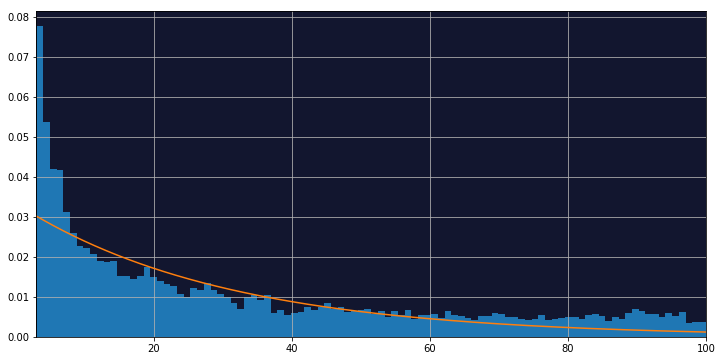

In [43]:
qa_data = questions.merge(answers, left_on='questions_id', right_on='answers_question_id')

que_age = pd.to_datetime(qa_data['answers_date_added']) - pd.to_datetime(qa_data['questions_date_added'])
que_age = que_age.apply(lambda x: x.days + np.round(x.seconds / 3600) / 24)


#plt.figure(figsize=(20,10))
fig, ax = plt.subplots(figsize=(12,6))

# Select only ages in range [3, 100] and plot their historgram
cut_que_age = que_age[(que_age < 100) & (que_age > 3)]
cut_que_age.hist(bins=100, density=True)

# Set parameter lambda of exponential distribution
mean = 30
lambd = 1 / mean

# Plot exponential distribution
x = np.linspace(0, 100, 1000)
y = lambd * np.exp(-lambd * x)

ax.plot(x, y)
ax.set_xlim(3, 100)

plt.show()

So, its final value is $ \frac{1}{30} $.  

So, for sampling negative pair, we choose a random question, sample random current time and sample random professional among those who registered at the current time and who were not forming positive pair with selected question.
For given tuple of the question, student and professional, we use their features at a current time. The final batch consists of equal amounts of positive and negative pairs.

In [44]:
class BatchGenerator(keras.utils.Sequence):
    """
    Class to ingest data from pre-processed DataFrames to model
    in form of batches of NumPy arrays
    """
    
    exp_mean = 30
    
    def __init__(self, que: pd.DataFrame, stu: pd.DataFrame, pro: pd.DataFrame,
                 batch_size: int, pos_pairs: list, nonneg_pairs: list, pro_dates: dict):
        """
        :param que: pre-processed questions data
        :param stu: pre-processed students data
        :param pro: pre-processed professionals data
        :param batch_size: actually, half of the real batch size
        Number of both positive and negative pairs present in generated batch
        :param pos_pairs: tuples of question, student and professional, which form positive pair
        (professional answered on the given question from corresponding student)
        :param nonneg_pairs: tuples of question, student and professional, which are known to form a positive pair.
        Superset of pos_pairs, used in sampling of negative pairs
        :param pro_dates: mappings from professional's id to his registration date
        """
        self.batch_size = batch_size

        # extract mappings from question's id to question's date and features
        que_ar = que.values
        self.que_feat = {que_ar[i, 0]: que_ar[i, 2:] for i in range(que_ar.shape[0])}
        self.que_time = {que_ar[i, 0]: pd.Timestamp(que_ar[i, 1]) for i in range(que_ar.shape[0])}

        self.pos_pairs = pos_pairs
        self.on_epoch_end()  # shuffle pos_pairs
        self.nonneg_pairs = {(que, stu, pro) for que, stu, pro, time in nonneg_pairs}

        # these lists are used in sampling of negative pairs
        self.ques_stus_times = [(que, stu, self.que_time[que]) for que, stu, pro, time in pos_pairs]

        self.pros = np.array([pro for que, stu, pro, time in nonneg_pairs])
        self.pros_times = np.array([pro_dates[pro] for que, stu, pro, time in nonneg_pairs])

        # simultaneously sort two arrays containing professional features
        sorted_args = np.argsort(self.pros_times)
        self.pros = self.pros[sorted_args]
        self.pros_times = self.pros_times[sorted_args]

        # extract mappings from student's id to student's date and features
        self.stu_feat = {}
        self.stu_time = {}
        for stu_id, group in stu.groupby('students_id'):
            group_ar = group.values[:, 1:]
            self.stu_feat[stu_id] = np.array([group_ar[i, 1:] for i in range(group_ar.shape[0])])
            self.stu_time[stu_id] = np.array([group_ar[i, 0] for i in range(group_ar.shape[0])])

        # extract mappings from professional's id to professional's date and features
        self.pro_feat = {}
        self.pro_time = {}
        for pro_id, group in pro.groupby('professionals_id'):
            group_ar = group.values[:, 1:]
            self.pro_feat[pro_id] = np.array([group_ar[i, 1:] for i in range(group_ar.shape[0])])
            self.pro_time[pro_id] = np.array([group_ar[i, 0] for i in range(group_ar.shape[0])])

    def __len__(self):
        return len(self.pos_pairs) // self.batch_size

    @staticmethod
    def __find(feat_ar: np.ndarray, time_ar: np.ndarray, search_time):
        pos = np.searchsorted(time_ar[1:], search_time)
        assert time_ar[pos] is pd.NaT or time_ar[pos] < search_time
        return feat_ar[pos]

    def __convert(self, pairs: list) -> (np.ndarray, np.ndarray):
        """
        Convert list of pairs of ids to NumPy arrays
        of question and professionals features
        """
        x_que, x_pro, current_times = [], [], []
        for que, stu, pro, current_time in pairs:
            que_data = self.que_feat[que]

            # find student's and professional's feature at current time
            stu_data = BatchGenerator.__find(self.stu_feat[stu], self.stu_time[stu], current_time)
            pro_data = BatchGenerator.__find(self.pro_feat[pro], self.pro_time[pro], current_time)

            # prepare current time as feature itself
            current_time = current_time.year + (current_time.dayofyear + current_time.hour / 24) / 365
            current_times.append(current_time)

            x_que.append(np.hstack([stu_data, que_data]))
            x_pro.append(pro_data)

        # and append them to both questions and professionals
        return np.vstack(x_que), np.vstack(x_pro)

    def __getitem__(self, index):
        """
        Generate the batch
        """
        pos_pairs = self.pos_pairs[self.batch_size * index: self.batch_size * (index + 1)]
        neg_pairs = []

        for i in range(len(pos_pairs)):
            while True:
                # sample question, its student and time
                que, stu, zero = random.choice(self.ques_stus_times)
                # calculate shift between question's and current time
                shift = np.random.exponential(BatchGenerator.exp_mean)
                current_time = zero + pd.Timedelta(int(shift * 24 * 60), 'm')
                # find number of professionals with registration date before current time
                i = np.searchsorted(self.pros_times, current_time)
                if i != 0:
                    break

            while True:
                # sample professional for negative pair
                pro = random.choice(self.pros[:i])
                # check if he doesn't form a positive pair
                if (que, stu, pro) not in self.nonneg_pairs:
                    neg_pairs.append((que, stu, pro, current_time))
                    break

        # convert lists of pairs to NumPy arrays of features
        x_pos_que, x_pos_pro = self.__convert(pos_pairs)
        x_neg_que, x_neg_pro = self.__convert(neg_pairs)

        # return the data in its final form
        return [np.vstack([x_pos_que, x_neg_que]), np.vstack([x_pos_pro, x_neg_pro])], \
               np.vstack([np.ones((len(x_pos_que), 1)), np.zeros((len(x_neg_que), 1))])

    def on_epoch_end(self):
        # shuffle positive pairs
        self.pos_pairs = random.sample(self.pos_pairs, len(self.pos_pairs))

In [45]:
# mappings from professional's id to his registration date. Used in batch generator
pro_to_date = {row['professionals_id']: row['professionals_date_joined'] for i, row in professionals.iterrows()}

In [46]:
bg = BatchGenerator(que_data, stu_data, pro_data, 64, pos_pairs, pos_pairs, pro_to_date)

## 8. Neural Network Architecture <a id="nna"></a>

### General Idea <a id="nna_general_idea"></a>

When designing model architecture, we had several requirements for it:
- Ability to be trained on solving binary classification task of prediction whether the given question and professional form a positive pair
- Ability to be generalized well for finding the most similar entities for building a recommendation engine
- Ability to simultaneously consider features of any nature
- Low variance not to overfit on a small amount of training data  

Apart from that, there were some properties our model would nice to have:
- Ability to process question's and professional's data separately, for possible optimizations
- Assurance of the possibility of a fast and straightforward finding of most similar entities

Such a long list of requirements was the reason why the only viable option for us from the beginning was neural networks. The final architecture meets all of them, and here it is:

![model](https://drive.google.com/uc?id=1vol5ixKhuJ9bwaEzqUh8tVohutYE8CL9)

Let's take a closer look at it.
- The main parts of the model are two separate encoders, for both questions and professionals. They consist of two dense layers, which transform preprocessed features into latent space of fixed dimension.
- Our objective is to train model in a way that makes encoders produce close latent representations for similar questions, professionals and positive question-professional pairs. To ensure that, first we compute the euclidian distance between latent vectors. Then, we pass it through an activation function, which in our case is $ e^{-x} $. That way, ideally we will have similar latent vectors for positive question-professional pairs, with zero distance and activation value of 1. On negative pairs, respectively, we wish to maximize the distance between their latent vectors, and output of our network to have a value of 0.

To sum it up, our model can be though of as such function of inputs q (questions) and p (professionals):
$$ nn(q, p) = e^{-\sqrt{(E_{p}(p)^2 - E_{q}(q)^2}} $$
where $ E_{p} $ and $ E_{q} $ are two encoders which can be though of as linear operators, which they are in case of single layer.  
Some other notes and properties of our models: 
- Numerical, textual and datetime-like features are easy to make suitable for the neural network. That's not the case with categorical features. However, there is a helpful tool, which is embedding layers. We pass each categorical feature values separately through the embedding layer, that gives us a dense numerical representation for each category. Then, we concatenate them with the rest numerical features. That helps us to consider all the data simultaneously with a small amount of parameters.
- Notice, that with that architecture we have all the costly operations on question's and professional's features separate. That allows us to precompute latent vectors for known questions and professional to save on computational time when finding similar entities.
- Also notice, that the most similar questions and professionals have the lowest euclidian distance between them. Euclidian distance is a ubiquitous metric and there are quite a few data structures that help us to optimize finding of the closest latent vectors and to achieve the fastest possible recommendations eventually.
- We have also added L2 regularization on weights connected with question's tags embeddings, and professional's averaged answered question's embedding. That way we merely lost on model performance but gained higher feature importance on other features - question's text and professional's tags, industry and headline. With that, our model is much more robust to missing parts of data (because it pays equal attention to all the features). Also, with that, we solved a cold start problem for professionals - otherwise, predictions for professionals with no answer history (and with zeroed average question embedding) were significantly less meaningful compared to other. 
- Siamese networks inspired this architecture.

This architecture we named DistanceModel, and there were others as well. Two of them are:
- ConcatModel. Instead of calculating euclidian distance and passing it through unusual activation, we concatenate latent vectors and pass them through some dense layers.
- SimpleModel. Instead of concatenating latent vectors, we concatenate preprocessed feature vectors directly and pass that through dense layers.

![models](https://drive.google.com/uc?id=1wmx-cWuJvzY3eN_gXd8b5qXVadZkv71d)

All of the models gave approximately similar results, but because only DistanceModel has a bunch of nice mentioned properties, we decided to stick with it. Summarization of all three model performances on same set of features presented in the table below: 

![model_summary](https://drive.google.com/uc?id=11BzYsRLyieEZzapOP22Y4gB8FZcxGOos)

### Simple explanation <a id="nna_simple_explanation"></a>

As was mentioned in [EDA](#eda), it would be handy to take into account all the existing features and find some way to balance between them in our recommendation decision automatically.

Existing data gives us beneficial knowledge of what worked and what didn't in terms of question answering between the students and the professionals. So we decided to use that knowledge and sort of build our latent space based on that. Such a classification task puts positive students, questions and professionals features closer to each other. Moreover, this is useful not only in terms of static features such as *locations*, *headlines*, etc. but also in previous interactions. Even students/questions **generalized** tags mapped to professionals **specialised** tags automatically just solving such optimization task on existing data.

So, that's pretty much it. That's how you can think of such a transfer learning approach.

### Training <a id="nna_training"></a>

It's important to understand that we don't want our model to reach 0.9+ accuracy because we use this optimization task for automatic balancing between the features for the decision. We derived, that 0.75 accuracy is optimal for our task because it would find the similarities and differences between the entities in a way that even **cold start** problem for question and professional can be solved.

For example, we have professional with no answers, so no statistical features, but he has tags, these tags help us to find enough questions for him, based on "what worked previously" knowledge for similar question and professional. So even if there is no similar question and professional, we are able to map their features and find at least something which maximizes the probability of answering the question.   

In case professional has no tags, recommendations are based on the **probabilistic** approach, and **activity** features explained later.

Model architecture is implemented in DistanceModel class, which aggregates two Encoder objects and is inherited from keras.Model

In [47]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Lambda, Embedding, Concatenate, Layer
from keras.optimizers import Adam


def l2_reg_last_n(alpha: float, n: int):
    """
    Adds L2 regularization on weights connected with the last n features with multiplier alpha
    """
    return lambda w: alpha * tf.reduce_mean(tf.square(w[-n:, :]))


def categorize(inputs: tf.Tensor, emb_input_dims: list, emb_output_dims: list):
    """
    Replaces categorical features with trainable embeddings

    :param inputs: tensor with encoded categorical features in first columns
    :param emb_input_dims: number of unique classes in categorical features
    :param emb_output_dims: embedding dimensions of categorical features
    :return: transformed tensor
    """
    n_embs = len(emb_input_dims)

    if n_embs > 0:
        embs = []

        # iterate over categorical features
        for i, nunique, dim in zip(range(n_embs), emb_input_dims, emb_output_dims):
            # separate their values with Lambda layer
            tmp = Lambda(lambda x: x[:, i])(inputs)
            # pass them through Embedding layer
            embs.append(Embedding(nunique, dim)(tmp))

        # pass all the numerical features directly
        embs.append(Lambda(lambda x: x[:, n_embs:])(inputs))
        # and concatenate them
        outputs = Concatenate()(embs)
    else:
        outputs = inputs

    return outputs


class Encoder(Model):
    """
    Model for extraction of high-level feature vector from question or professional
    """

    def __init__(self, input_dim: int, inter_dim: int, output_dim: int, emb_input_dims: list, emb_output_dims: list,
                 reg: float = 0.0):
        """
        :param input_dim: dimension of raw feature vector
        :param inter_dim: dimension of intermediate layer
        :param output_dim: dimension of computed high-level feature vector
        :param emb_input_dims: number of unique classes in categorical features
        :param emb_output_dims: embedding dimensions of categorical features
        :param reg:
        """
        self.inputs = Input((input_dim,))
        self.categorized = categorize(self.inputs, emb_input_dims, emb_output_dims)

        # here goes main dense layers
        self.inter = Dense(inter_dim, activation='tanh',
                           kernel_regularizer=l2_reg_last_n(reg, 10))(self.categorized)

        self.outputs = Dense(output_dim)(self.inter)

        super().__init__(self.inputs, self.outputs)


class DistanceModel(Model):
    """
    Main model which combines two encoders (for questions and professionals),
    calculates distance between high-level feature vectors and applies activation
    """

    def __init__(self, que_dim: int, que_input_embs: list, que_output_embs: list,
                 pro_dim: int, pro_input_embs: list, pro_output_embs: list,
                 inter_dim: int, output_dim: int):
        """
        :param que_dim: dimension of question's raw feature vector
        :param que_input_embs: number of unique classes in question's categorical features
        :param que_output_embs: embedding dimensions of question's categorical features
        :param pro_dim: dimension of professional's raw feature vector
        :param pro_input_embs: number of unique classes in professional's categorical features
        :param pro_output_embs: embedding dimensions of professional's categorical features
        :param inter_dim: dimension of Encoder's intermediate layer
        :param output_dim: dimension of high-level feature vectors
        """
        super().__init__()

        # build an Encoder model for questions
        self.que_model = Encoder(que_dim, inter_dim, output_dim, que_input_embs, que_output_embs, reg=2.0)
        # same for professionals
        self.pro_model = Encoder(pro_dim, inter_dim, output_dim, pro_input_embs, pro_output_embs, reg=0.2)

        # calculate distance between high-level feature vectors
        self.merged = Lambda(lambda x: tf.reduce_sum(tf.square(x[0] - x[1]), axis=-1))(
            [self.que_model.outputs[0], self.pro_model.outputs[0]])
        # and apply activation - e^-x here, actually
        self.outputs = Lambda(lambda x: tf.reshape(tf.exp(-self.merged), (-1, 1)))(self.merged)

        super().__init__([self.que_model.inputs[0], self.pro_model.inputs[0]], self.outputs)

In [48]:
model = DistanceModel(que_dim=len(que_data.columns) - 2 + len(stu_data.columns) - 2,
                      que_input_embs=[102, 42], que_output_embs=[2, 2],
                      pro_dim=len(pro_data.columns) - 2,
                      pro_input_embs=[102, 102, 42], pro_output_embs=[2, 2, 2],
                      inter_dim=20, output_dim=10)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 38)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None,)              0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None,)              0           input_1[0][0]                    
_____________________________________

In [49]:
for lr, epochs in zip([0.01, 0.001, 0.0001, 0.00001], [5, 10, 10, 5]):
    model.compile(Adam(lr=lr), loss='binary_crossentropy', metrics=['accuracy'])
    model.fit_generator(bg, epochs=epochs, verbose=2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
 - 11s - loss: 0.6186 - acc: 0.6843
Epoch 2/5
 - 11s - loss: 0.5692 - acc: 0.7172
Epoch 3/5
 - 10s - loss: 0.5620 - acc: 0.7203
Epoch 4/5
 - 11s - loss: 0.5590 - acc: 0.7232
Epoch 5/5
 - 10s - loss: 0.5607 - acc: 0.7230
Epoch 1/10
 - 11s - loss: 0.5270 - acc: 0.7477
Epoch 2/10
 - 10s - loss: 0.5238 - acc: 0.7498
Epoch 3/10
 - 11s - loss: 0.5199 - acc: 0.7535
Epoch 4/10
 - 10s - loss: 0.5194 - acc: 0.7537
Epoch 5/10
 - 10s - loss: 0.5174 - acc: 0.7558
Epoch 6/10
 - 10s - loss: 0.5169 - acc: 0.7565
Epoch 7/10
 - 11s - loss: 0.5162 - acc: 0.7568
Epoch 8/10
 - 10s - loss: 0.5141 - acc: 0.7592
Epoch 9/10
 - 10s - loss: 0.5131 - acc: 0.7585
Epoch 10/10
 - 11s - loss: 0.5129 - acc: 0.7575
Epoch 1/10
 - 11s - loss: 0.5064 - acc: 0.7629
Epoch 2/10
 - 10s - loss: 0.5045 - acc: 0.7654
Epoch 3/10
 - 10s - loss: 0.5071 - acc: 0.7639
Epoch 4/10
 - 10s - loss: 0.5050 - acc: 0.7653
Epoch 5/10
 - 11s - loss: 0.5041 - acc: 0.7660
Epoch 6/10
 - 10

### Evaluation <a id="nna_evaluation"></a>

For describing the model, feature importance is really nice information to have. One of the approaches for calculating feature importance in neural networks is permutation importance. We shuffle feature values randomly one by one and measure how the loss function is affected.

permutation_importance() function implements calculating of feature importances, plot_fi() displays them

In [50]:
from sklearn.utils import shuffle

def permutation_importance(model: keras.models.Model, x_que: np.ndarray, x_pro: np.ndarray, y: np.ndarray,
                           fn: dict, n_trials: int) -> pd.DataFrame:
    """
    Calculate model feature importance via random permutations of feature values

    :param model: model to evaluate
    :param x_que: pre-processed questions data
    :param x_pro: pre-processed professionals data
    :param y: target labels
    :param fn: dict with feature names of both questions and professionals
    :param n_trials: number of shuffles for each feature
    :return: Pandas DataFrame with importance of each feature
    """
    # model performance on normal, non-shuffled data
    base_loss, base_acc = model.evaluate([x_que, x_pro], y)
    losses = []
    for i, name in enumerate(fn['que'] + fn['pro']):
        loss = 0
        for j in range(n_trials):
            x_que_i, x_pro_i = copy.deepcopy(x_que), copy.deepcopy(x_pro)

            if name in fn['que']:
                x_que_i[:, i] = shuffle(x_que_i[:, i])
            else:
                x_pro_i[:, i - len(fn['que'])] = shuffle(x_pro_i[:, i - len(fn['que'])])
            loss += model.evaluate([x_que_i, x_pro_i], y, verbose=0)[0]

        losses.append(loss / n_trials)

    fi = pd.DataFrame({'importance': losses}, index=fn['que'] + fn['pro'])
    fi.sort_values(by='importance', inplace=True, ascending=True)
    fi['importance'] -= base_loss

    return fi


def plot_fi(fi, title='Feature importances via shuffle', xlabel='Change in loss after shuffling feature\'s values'):
    """
    Nicely plot Pandas DataFrame with feature importance
    """
    def get_color(feature: str):
        if feature.startswith('que'):
            if '_emb_' in feature:
                return 'royalblue'
            else:
                return 'cornflowerblue'
        elif feature.startswith('pro'):
            if '_emb_' in feature:
                return 'firebrick'
            else:
                return 'indianred'
        else:
            return 'seagreen'

    fi['color'] = fi.index.map(get_color)
    fig, ax = plt.subplots(figsize=(8, 20))
    plt.barh(fi.index, fi.importance, color=fi.color)
    plt.title(title, fontsize=20)
    plt.xlabel(xlabel, fontsize=15)
    ax.yaxis.tick_right()
    plt.show()

2048/2048 [==============================] - 0s 115us/step


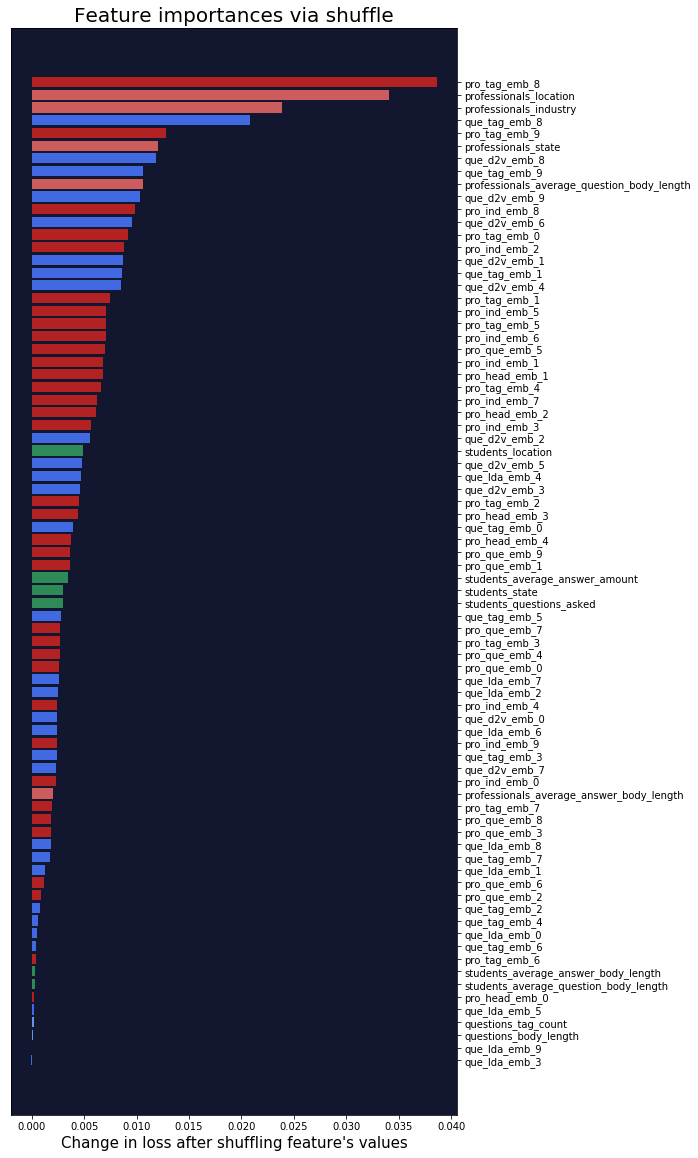

In [51]:
# dummy batch generator used to extract single big batch of data to calculate feature importance
bg = BatchGenerator(que_data, stu_data, pro_data, 1024, pos_pairs, pos_pairs, pro_to_date)

# dict with descriptions of feature names, used for visualization of feature importance
fn = {"que": list(stu_data.columns[2:]) + list(que_data.columns[2:]),
      "pro": list(pro_data.columns[2:])}

# calculate and plot feature importance
fi = permutation_importance(model, bg[0][0][0], bg[0][0][1], bg[0][1], fn, n_trials=3)
plot_fi(fi)

Another nice information to see is categorical features embeddings trained by model

In [52]:
def vis_model_emb(layer, names, title):
    """
    Visualize embeddings of a single feature
    """
    emb = layer.get_weights()[0]
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.scatter(emb[:, 0], emb[:, 1], s=90, c='#69f0ff')
    for i, name in enumerate(names):
        ax.annotate(name, (emb[i, 0], emb[i, 1]), color='w')
    plt.title(title)

Here we display how they look like in case of student's and professional's states

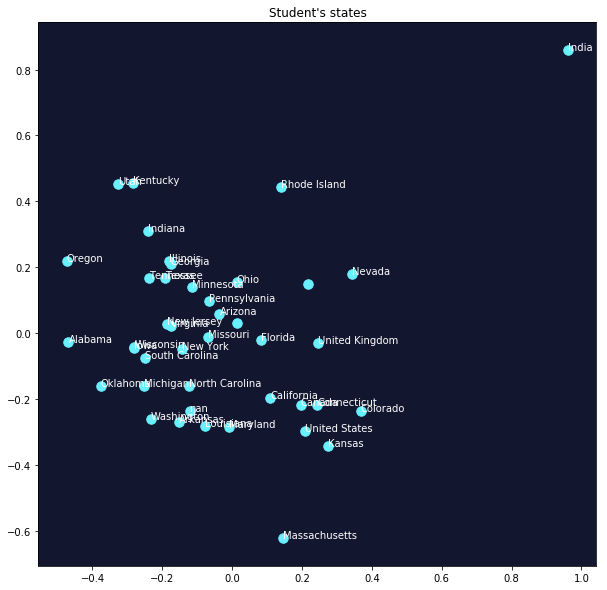

In [53]:
vis_model_emb(model.get_layer('embedding_2'), stu_proc.pp['students_state'].classes_, "Student's states")

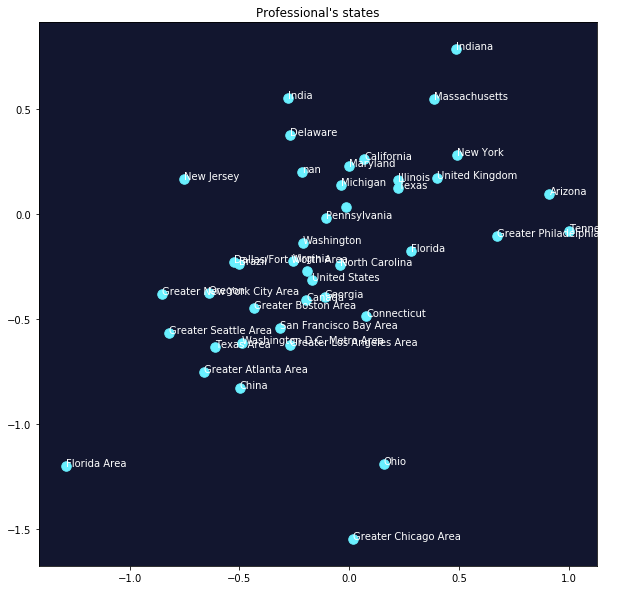

In [54]:
vis_model_emb(model.get_layer('embedding_5'), pro_proc.pp['professionals_state'].classes_, "Professional's states")

### Test <a id="nna_test"></a>

To evaluate model performance on test set, we compute each entity features on full data. This adds new feature vectors that correspond to answers after SPLIT_DATE, and they are computed using data after SPLIT_DATE.  
Positive pairs are formed from questions and professionals where professional gave an answer to that question after SPLIT_DATE

In [55]:
# non-negative pairs are all known positive pairs to the moment
nonneg_pairs = pos_pairs

# extract positive pairs
pos_pairs = list(pairs_df.loc[pairs_df['answers_date_added'] >= SPLIT_DATE].itertuples(index=False, name=None))
nonneg_pairs += pos_pairs

# extract and preprocess feature for all three main entities

que_proc = QueProc(tag_embs, ques_d2v, lda_dic, lda_tfidf, lda_model)
que_data = que_proc.transform(questions, tag_que)

stu_proc = StuProc()
stu_data = stu_proc.transform(students, questions, answers)

pro_proc = ProProc(tag_embs, ind_embs, head_d2v, ques_d2v)
pro_data = pro_proc.transform(professionals, questions, answers, tag_pro)

# initialize batch generator
bg = BatchGenerator(que_data, stu_data, pro_data, 64, pos_pairs, nonneg_pairs, pro_to_date)

In [56]:
loss, acc = model.evaluate_generator(bg)
print(f'Loss: {loss}, accuracy: {acc}')

Loss: 0.5072127305544339, accuracy: 0.7680288461538461


## 9. Recommendation engine <a id="re"></a>

### Intro <a id="re_intro"></a>

Recommender engine should take into account the metrics derived from the discussion:

A good recommender system for CareerVillage.org is effective at helping reach a high 95% percent of questions which get a 10-quality-point answer within 24 hours, without churning out Pros, and within the bounds of fairness. 

*Percent of questions:* It's important that students feel that they can trust the CV community to be there for them, no matter what their career question is.

*Receiving a:* Literally "a" meaning "at least one". CV wants questions to be answered multiple times, but it's much more important to get at least one answer than it is to go from the second answer to the third answer.

*Within 24 hours:* Speed matters because it matters to the students. In addition, there is an insight that when a student asks a question and does not get an answer within 3 days, his likelihood of ever asking a question again drops a lot.

*Without churning out Pros:* Must ensure that the emails sent are not pestering people so much that they can't remain with CV.

*Within the bounds of fairness:* It's critically important. Recommendation system must work well for questions from wealthy, well-connected, generally-well-resourced students the as for everyone else.

Scoring of system features by importance:
1. No question left behind
2. Matches should feel “relevant” to the professionals
3. Don’t churn the professionals (too much email → feels like spam → people leave)
4. Speed to first answer
5. Works for newbies (solution for the cold start problem for new Professionals)
6. Something in common (Place, School, Group)
7. \# of answers per question
8. Interacted before?
9. Bonus: Quality.

We will split the definition of recommender functionality into two parts:
- Content-based recommendations 
- Activity-based recommendations

### Content Based<a id="re_content_based"></a>

Our Neural Network trained on "content" features is already a generalized way to solve the main recommender tasks:
1. Once a student writes a question, the engine should simultaneously find similar questions which could help him to find already provided answers or help with the formulation of his own question.
2. New questions should be answered quickly. For this reason, it should be forwarded to professionals who can answer the questions best.
3. Find the list of most relevant questions for professional to answer. They can be sent to professional by email

In order to use our Neural Network for recommendations, we defined a Predictor class with all the necessary functions for each of the three initial recommender problems.

We have three main methods for each problem:
- find_ques_by_que
- find_pros_by_que
- find_ques_by_pro

Also, we can even find similar professional given the professional.  

All the methods run in a few milliseconds. That speed is achieved by precomputing latent vectors of existing questions and professionals and storing them in special data structure named K-d tree, which is high-dimensional binary search tree. Thus, for each new entity (professional or student) we only compute its latent vector and find entities with similar latent vector in logarithmic time on average.

This gives us a generalized content-based recommender which combines and scores all the content features automatically and puts them in the space which is created while solving optimization problem on existing success/failure in answered / unanswered questions by professionals.

The model will be improved over time with each new question/answer.

Predictor class handles all the main computational stuff of finding most similar entities given entity. Also it checks that entity we found has not formed positive pair with given yet.

In [57]:
from sklearn.neighbors import KDTree

class Predictor:
    """
    Class for handling closest professionals or questions queries
    """

    def __init__(self, model: keras.Model, que_data: pd.DataFrame, stu_data: pd.DataFrame, pro_data: pd.DataFrame,
                 que_proc: QueProc, pro_proc: ProProc, que_to_stu: dict, pos_pairs: list):
        """
        :param model: compiled Keras model
        :param que_data: processed questions's data
        :param stu_data: processed student's data
        :param pro_data: processed professional's data
        :param que_proc: question's data processor
        :param pro_proc: professional's data processor
        :param que_to_stu: mappings from question's id to its author id
        :param pos_pairs: list of positive question-student-professional-time pairs
        """
        self.model = model

        # construct mappings from entity id to features
        self.que_dict = {row.values[0]: row.values[2:] for i, row in que_data.iterrows()}
        self.stu_dict = {stu: group.values[-1, 2:] for stu, group in stu_data.groupby('students_id')}
        self.pro_dict = {pro: group.values[-1, 2:] for pro, group in pro_data.groupby('professionals_id')}
        
        self.entity_to_paired = dict()
        
        # construct mappings from entity to other entities it was in positive pair
        for que, stu, pro, time in pos_pairs:
            if que not in self.entity_to_paired:
                self.entity_to_paired[que] = {pro}
            else:
                self.entity_to_paired[que].add(pro)
                
            if pro not in self.entity_to_paired:
                self.entity_to_paired[pro] = {que}
            else:
                self.entity_to_paired[pro].add(que)

        # form final features for 1all known questions and professionals

        que_feat, que_ids, pro_feat, pro_ids = [], [], [], []

        for que in self.que_dict.keys():
            cur_stu = que_to_stu[que]
            if cur_stu in self.stu_dict:
                # actual question's features are both question and student's features
                que_feat.append(np.hstack([self.stu_dict[cur_stu], self.que_dict[que]]))
                que_ids.append(que)

        for pro in self.pro_dict.keys():
            pro_feat.append(self.pro_dict[pro])
            pro_ids.append(pro)

        self.pro_feat = np.vstack(pro_feat)
        self.pro_ids = np.vstack(pro_ids)
        self.que_feat = np.vstack(que_feat)
        self.que_ids = np.vstack(que_ids)

        # create two encoders
        self.que_model = model.que_model
        self.pro_model = model.pro_model

        # compute latent vectors for questions and professionals
        self.que_lat_vecs = self.que_model.predict(self.que_feat)
        self.pro_lat_vecs = self.pro_model.predict(self.pro_feat)

        # create KDTree trees from question and professional latent vectors
        self.que_tree = KDTree(self.que_lat_vecs)
        self.pro_tree = KDTree(self.pro_lat_vecs)

        # initialize preprocessors
        self.que_proc = que_proc
        self.pro_proc = pro_proc

    def __get_que_latent(self, que_df: pd.DataFrame, que_tags: pd.DataFrame) -> np.ndarray:
        """
        Get latent vectors for questions in raw format
        """
        que_df['questions_date_added'] = pd.to_datetime(que_df['questions_date_added'])

        # extract and preprocess question's features
        que_feat = self.que_proc.transform(que_df, que_tags).values[:, 2:]

        # actual question's features are both question and student's features
        stu_feat = np.vstack([self.stu_dict[stu] for stu in que_df['questions_author_id']])
        que_feat = np.hstack([stu_feat, que_feat])

        # encode question's data to get latent representation
        lat_vecs = self.que_model.predict(que_feat)

        return lat_vecs

    def __get_pro_latent(self, pro_df: pd.DataFrame, que_df: pd.DataFrame, ans_df: pd.DataFrame,
                         pro_tags: pd.DataFrame) -> np.ndarray:
        """
        Get latent vectors for professionals in raw format
        """
        pro_df['professionals_date_joined'] = pd.to_datetime(pro_df['professionals_date_joined'])
        que_df['questions_date_added'] = pd.to_datetime(que_df['questions_date_added'])
        ans_df['answers_date_added'] = pd.to_datetime(ans_df['answers_date_added'])

        # extract and preprocess professional's features
        pro_feat = self.pro_proc.transform(pro_df, que_df, ans_df, pro_tags)

        # select the last available version of professional's features
        pro_feat = pro_feat.groupby('professionals_id').last().values[:, 1:]
        
        # encode professional's data to get latent representation
        lat_vecs = self.pro_model.predict(pro_feat)

        return lat_vecs

    def __construct_df(self, ids, sims, scores):
        scores = np.around(scores, 4)
        tuples = []
        for i, cur_id in enumerate(ids):
            for j, sim in enumerate(sims[i]):
                if sim[0] not in self.entity_to_paired.get(cur_id, {}):
                    tuples.append((cur_id, sim[0], scores[i, j]))
        score_df = pd.DataFrame(tuples, columns=['id', 'match_id', 'match_score'])
        return score_df

    def __get_ques_by_latent(self, ids: np.ndarray, lat_vecs: np.ndarray, top: int) -> pd.DataFrame:
        """
        Get top questions with most similar latent representations to given vectors
        """
        dists, ques = self.que_tree.query(lat_vecs, k=top)
        ques = self.que_ids[ques]
        scores = np.exp(-dists)
        return self.__construct_df(ids, ques, scores)

    def __get_pros_by_latent(self, ids: np.ndarray, lat_vecs: np.ndarray, top: int) -> pd.DataFrame:
        """
        Get top professionals with most similar latent representations to given vectors
        """
        dists, pros = self.pro_tree.query(lat_vecs, k=top)
        pros = self.pro_ids[pros]
        scores = np.exp(-dists)
        return self.__construct_df(ids, pros, scores)

    def find_pros_by_que(self, que_df: pd.DataFrame, que_tags: pd.DataFrame, top: int = 10) -> pd.DataFrame:
        """
        Get top professionals with most similar internal representation to given questions

        :param que_df: question's data in raw format
        :param que_tags: questions's tags in raw format
        :param top: number of professionals for each question to return
        :return: dataframe of question's ids, matched professional's ids and similarity scores
        """
        lat_vecs = self.__get_que_latent(que_df, que_tags)
        return self.__get_pros_by_latent(que_df['questions_id'].values, lat_vecs, top)

    def find_ques_by_que(self, que_df: pd.DataFrame, que_tags: pd.DataFrame, top: int = 10) -> pd.DataFrame:
        """
        Get top questions with most similar internal representation to given questions

        :param que_df: question's data in raw format
        :param que_tags: questions's tags in raw format
        :param top: number of questions for each question to return
        :return: dataframe of question's ids, matched question's ids and similarity scores
        """
        lat_vecs = self.__get_que_latent(que_df, que_tags)
        return self.__get_ques_by_latent(que_df['questions_id'].values, lat_vecs, top)

    def find_ques_by_pro(self, pro_df: pd.DataFrame, que_df: pd.DataFrame, ans_df: pd.DataFrame,
                         pro_tags: pd.DataFrame, top: int = 10) -> pd.DataFrame:
        """
        Get top questions with most similar internal representation to given professional

        :param pro_df: professional's data in raw format
        :param que_df: question's data in raw format
        :param ans_df: answer's data in raw format
        :param pro_tags: professional's tags data in raw format
        :param top: number of questions for each professional to return
        :return: dataframe of professional's ids, matched question's ids and similarity scores
        """
        lat_vecs = self.__get_pro_latent(pro_df, que_df, ans_df, pro_tags)
        return self.__get_ques_by_latent(pro_df['professionals_id'].values, lat_vecs, top)

    def find_pros_by_pro(self, pro_df: pd.DataFrame, que_df: pd.DataFrame, ans_df: pd.DataFrame,
                         pro_tags: pd.DataFrame, top: int = 10) -> pd.DataFrame:
        """
        Get top professionals with most similar internal representation to given professional

        :param pro_df: professional's data in raw format
        :param que_df: question's data in raw format
        :param ans_df: answer's data in raw format
        :param pro_tags: professional's tags data in raw format
        :param top: number of questions for each professional to return
        :return: dataframe of professional's ids, matched professional's ids and similarity scores
        """
        lat_vecs = self.__get_pro_latent(pro_df, que_df, ans_df, pro_tags)
        return self.__get_pros_by_latent(pro_df['professionals_id'].values, lat_vecs, top)

Formatter class is needed for visual representation and ability to compare the results

In [58]:
class Formatter:
    """
    Class with useful for Predictor input/output functionality
    """

    def __init__(self, data_path: str):
        pro = pd.read_csv(data_path + 'professionals.csv')
        que = pd.read_csv(data_path + 'questions.csv')

        tags = pd.read_csv(data_path + 'tags.csv')
        tag_users = pd.read_csv(data_path + 'tag_users.csv')
        tag_que = pd.read_csv(data_path + 'tag_questions.csv')

        tag_merged = tags.merge(tag_users, left_on='tags_tag_id', right_on='tag_users_tag_id')
        tags_grouped = tag_merged.groupby('tag_users_user_id').agg(lambda x: ' '.join(x))[['tags_tag_name']]
        self.pro = pro.merge(tags_grouped, left_on='professionals_id', right_index=True, how='left')

        tag_merged = tags.merge(tag_que, left_on='tags_tag_id', right_on='tag_questions_tag_id')
        tags_grouped = tag_merged.groupby('tag_questions_question_id').agg(lambda x: ' '.join(x))[['tags_tag_name']]
        self.que = que.merge(tags_grouped, left_on='questions_id', right_index=True, how='left')

    def get_que(self, scores: pd.DataFrame) -> pd.DataFrame:
        """
        Append all the question's data to question's scoring dataframe from Predictor

        :param scores: result of similar questions query on Predictor object
        :return: extended dataframe
        """
        return self.que.merge(scores, left_on='questions_id', right_on='match_id').sort_values('match_score',
                                                                                               ascending=False)

    def get_pro(self, scores: pd.DataFrame) -> pd.DataFrame:
        """
        Append all the professional's data to professional's scoring dataframe from Predictor

        :param scores: result of similar professionals query on Predictor object
        :return: extended dataframe
        """
        return self.pro.merge(scores, left_on='professionals_id', right_on='match_id').sort_values('match_score',
                                                                                                   ascending=False)

    @staticmethod
    def __convert_tuples(ids, tags):
        tuples = []
        for i, tgs in enumerate(tags):
            que = ids[i]
            for tag in tgs.split(' '):
                tuples.append((que, tag))
        return tuples

    @staticmethod
    def convert_que_dict(que_dict: dict) -> (pd.DataFrame, pd.DataFrame):
        """
        Converts dictionary of question data into desired form
        :param que_dict: dictionary of question data
        """
        # get DataFrame from dict
        que_df = pd.DataFrame.from_dict(que_dict)

        # create question-tag tuples
        tuples = Formatter.__convert_tuples(que_df['questions_id'].values, que_df['questions_tags'].values)

        # create DataFrame from tuples
        que_tags = pd.DataFrame(tuples, columns=['tag_questions_question_id', 'tags_tag_name'])
        que_df.drop(columns='questions_tags', inplace=True)

        que_tags['tags_tag_name'] = que_tags['tags_tag_name'].apply(lambda x: tp.process(x, allow_stopwords=True))
        que_df['questions_title'] = que_df['questions_title'].apply(tp.process)
        que_df['questions_body'] = que_df['questions_body'].apply(tp.process)
        que_df['questions_whole'] = que_df['questions_title'] + ' ' + que_df['questions_body']
        
        return que_df, que_tags

    @staticmethod
    def convert_pro_dict(pro_dict: dict) -> (pd.DataFrame, pd.DataFrame):
        """
        Converts dictionary of professional data into desired form
        :param pro_dict: dictionary of professional data
        """
        # get DataFrame from dict
        pro_df = pd.DataFrame.from_dict(pro_dict)
        pros = pro_df['professionals_id'].values

        # create professional-tag tuples
        tuples = Formatter.__convert_tuples(pro_df['professionals_id'].values,
                                            pro_df['professionals_subscribed_tags'].values)

        # create DataFrame from tuples
        pro_tags = pd.DataFrame(tuples, columns=['tag_users_user_id', 'tags_tag_name'])
        pro_df.drop(columns='professionals_subscribed_tags', inplace=True)
        
        pro_tags['tags_tag_name'] = pro_tags['tags_tag_name'].apply(lambda x: tp.process(x, allow_stopwords=True))
        pro_df['professionals_headline'] = pro_df['professionals_headline'].apply(tp.process)
        pro_df['professionals_industry'] = pro_df['professionals_industry'].apply(tp.process)

        return pro_df, pro_tags

In [59]:
# mappings from question's id to its author id. Used in Predictor
que_to_stu = {row['questions_id']: row['questions_author_id'] for i, row in questions.iterrows()}

In [60]:
predictor = Predictor(model, que_data, stu_data, pro_data, que_proc, pro_proc, que_to_stu, nonneg_pairs)

In [61]:
formatter = Formatter(DATA_PATH)

#### By question

To find relevant questions/professionals given question we also take into account student's features, as it is evident that the same questions regarding a career in different for example locations lead to different answers from different professionals. So with each question, we also take into account all possible features to find the most relevant similar questions. Also, our network helps us with this in a few lines of code.

In [62]:
que_sample_dict = {
    'questions_id': ['0'],
    'questions_author_id': ['02946e467bab4fd794e42f9670cb4279'],
    'questions_date_added': ['2017-07-29 13:30:50 UTC+0000'],
    'questions_title': ['I want to study law but not sure what subjects need to be taken,so need some advice on that.'],
    'questions_body': ['#law-practice #lawyer #career-details'],
    'questions_tags': ['lawyer law-practice career-details']
}

In [63]:
que_sample_df, que_sample_tags = formatter.convert_que_dict(que_sample_dict)

##### Similar questions
Here we find similar questions given question.

In [64]:
tmp = predictor.find_ques_by_que(que_sample_df, que_sample_tags)
formatter.get_que(tmp)

,questions_id,questions_author_id,questions_date_added,questions_title,questions_body,tags_tag_name,id,match_id,match_score
0,d6ee6363b5f7486eb362bc615630fda8,02946e467bab4fd794e42f9670cb4279,2017-07-29 13:30:50 UTC+0000,I want to study law but not sure what subjects...,#law-practice #lawyer #career-details,lawyer law-practice career-details,0,d6ee6363b5f7486eb362bc615630fda8,1.0000
4,25c410990004407c9c0b4fe47e8d2d9a,6d3bb23b86b54f32ba6b937e56f2eddc,2018-04-22 08:50:04 UTC+0000,What specific subjects do you need to be a law...,"I really want to be a lawyer,but i am just not...",barchelor,0,25c410990004407c9c0b4fe47e8d2d9a,0.8982
1,b4d00a878ef947988592041ff2889009,af8e0dc5444e4eb5ab7fab7789b58f4b,2017-02-09 18:15:12 UTC+0000,What collage courses should i take to become a...,I am totally confused please help me! #lawyer,lawyer,0,b4d00a878ef947988592041ff2889009,0.8980
8,17acc0f1fd0b49829b6724f7783b590d,9f8494d4c21d483a81d9e305132493a3,2017-02-09 19:36:32 UTC+0000,Do you have to learn certain course like math ...,I think being a lawyer you should be prepared ...,lawyer,0,17acc0f1fd0b49829b6724f7783b590d,0.8875
5,2c98ed8a65e74103b312c996376df9db,18e7756776ab43cfb4abf280b736abad,2018-01-16 23:05:49 UTC+0000,What’s the steps of becoming homocide detective,My dream has always to be a homocide detective...,law-enforcement,0,2c98ed8a65e74103b312c996376df9db,0.8846
6,eb23b7a634cc4df0a0bc23f70c247b99,d7f1201630914169a42c0922a5fdd629,2017-09-29 15:09:29 UTC+0000,"If my ultimate goal is to become a lawyer, wha...",I've been bombarded with fliers for dozens of ...,lawstudent,0,eb23b7a634cc4df0a0bc23f70c247b99,0.8709
2,7b2992fb104245279f2338ad7967ffb8,f86909bf66ca43d19083abdd4e599b0b,2018-01-16 13:44:02 UTC+0000,What qualifications are needed to work for the...,I want to be a forensic accountant for the FBI...,law-enforcement forensic accountant fbi future...,0,7b2992fb104245279f2338ad7967ffb8,0.8611
7,6db83425c2b34c0e9928bcc29effc8a9,411047cc7d764cb49383ecbe4708b3ac,2016-03-05 15:40:16 UTC+0000,What is the pay for an experienced lawyer?,"To become successful lawyer, about how much wo...",law lawyer compensation,0,6db83425c2b34c0e9928bcc29effc8a9,0.8584
9,0e96abce3f714dedb7979ef24b2780f0,462f315908d4485c969fb185c1bffa05,2018-03-02 20:04:32 UTC+0000,I would like to develop software for the Immig...,A large problem in our country is the amount o...,government defense immigration,0,0e96abce3f714dedb7979ef24b2780f0,0.8563
3,b8bdacfac8b84cbaa9fc895f2e68a9f9,fc53287a9ddf4068bbaf14bd229d2d2e,2016-02-02 18:00:40 UTC+0000,what does it takes to be a lawyer,i like debating . #college #law #lawyers,college law lawyers,0,b8bdacfac8b84cbaa9fc895f2e68a9f9,0.8562


##### Relevant professionals
Here we find relevant professionals by question.

In [65]:
tmp = predictor.find_pros_by_que(que_sample_df, que_sample_tags)
formatter.get_pro(tmp)

,professionals_id,professionals_location,professionals_industry,professionals_headline,professionals_date_joined,tags_tag_name,id,match_id,match_score
7,24851508301d441191600f0cb763332e,United States,Legal Services,NCCU Law Graduate,2018-10-04 13:44:24 UTC+0000,legal-services,0,24851508301d441191600f0cb763332e,0.8999
4,7e4c15b86fba4a01835041f75208ea74,Greater Philadelphia Area,Legal Services,Litigation Attorney,2017-09-28 21:02:04 UTC+0000,legal-services,0,7e4c15b86fba4a01835041f75208ea74,0.8975
0,e87643e0c06048d19410088222e3f14c,"Los Angeles, California",Legal Services,Attorney at Law,2016-03-03 18:41:30 UTC+0000,law-services,0,e87643e0c06048d19410088222e3f14c,0.8953
8,1919a81de8f04b089d8fbf3cd7316cc5,United States,Legal Services,Student at San Francisco State University,2019-01-23 21:18:28 UTC+0000,legal-services,0,1919a81de8f04b089d8fbf3cd7316cc5,0.8895
2,a4cf9fceb477485fa25879ee01af9976,"Houston, Texas",Legal Services,"Associate Attorney at Cook Legal Group, LLLP",2017-02-07 23:28:58 UTC+0000,legal-services,0,a4cf9fceb477485fa25879ee01af9976,0.8858
6,4fb2a7f4e6ae46f986840cccd105bca1,"Los Angeles, California",Legal Services,Immigration and Workers Compensation Attorney,2018-08-31 09:11:28 UTC+0000,legal-services,0,4fb2a7f4e6ae46f986840cccd105bca1,0.8847
3,be55769da5794ba4b489332f76af5305,Greater Los Angeles Area,Legal Services,"Associate Attorney at Land Legal Group, APC",2017-06-22 20:36:44 UTC+0000,legal-services,0,be55769da5794ba4b489332f76af5305,0.8845
1,ba74deb6eb5d46cba0537a2e47fd4048,"Chicago, Illinois",Law Practice,E-Discovery Services & Strategy Review Attorne...,2017-01-24 01:54:53 UTC+0000,law-practice legal-studies,0,ba74deb6eb5d46cba0537a2e47fd4048,0.8828
9,72116f3eae7c42899f4c3449528c16c1,Washington D.C. Metro Area,Legal Services,Trademark Paralegal seeking a new opportunity,2019-01-27 20:00:48 UTC+0000,legal-services,0,72116f3eae7c42899f4c3449528c16c1,0.8816
5,032d4506476a4fcb87065664e54fb850,"Miranda Area, Venezuela",Legal Services,Abogado en Escritorio Jurídico,2018-08-20 00:27:54 UTC+0000,legal-studies legal-services,0,032d4506476a4fcb87065664e54fb850,0.8815


#### By professional

The logic is pretty much the same as it was with question.

In [66]:
pro_sample_dict = {
    'professionals_id': ['eae09bbc30e34f008e10d5aa70d521b2'],
    'professionals_location': ['Narberth, Pennsylvania'],
    'professionals_industry': ['Veterinary'],
    'professionals_headline': ['Veterinarian'],
    'professionals_date_joined': ['2017-09-26 18:10:23 UTC+0000'],
    'professionals_subscribed_tags': ['veterinary #animal']
}

In [67]:
pro_sample_df, pro_sample_tags = formatter.convert_pro_dict(pro_sample_dict)

##### Relevant questions
Here we find relevant questions for professional.

In [68]:
tmp = predictor.find_ques_by_pro(pro_sample_df, questions, answers, pro_sample_tags)
formatter.get_que(tmp)

,questions_id,questions_author_id,questions_date_added,questions_title,questions_body,tags_tag_name,id,match_id,match_score
1,280ef77e033842238847372f0db81bd7,d8b3c3c671b242158250af1b9a0b9aa1,2014-10-08 20:03:48 UTC+0000,What would be the best undergraduate major to ...,"I want to become a veterinarian, but i have no...",veterinarian animals animal-health pet,eae09bbc30e34f008e10d5aa70d521b2,280ef77e033842238847372f0db81bd7,0.7065
9,9ca99b3b9cad44f6868f9328c9434a82,f1ef2a72594448839b89603fa012ecfd,2017-09-01 01:16:41 UTC+0000,What are some schools that have a good pre-vet...,I am interested in becoming a veterinarian and...,veterinary animals pre-vet,eae09bbc30e34f008e10d5aa70d521b2,9ca99b3b9cad44f6868f9328c9434a82,0.7056
4,0f9b9b509a5040ea88d712ab401d5a32,5c241057d9e146968b32472ec30785c0,2016-10-28 05:08:40 UTC+0000,Would you recommend pursuing grad school for s...,"I want to either research animals in the wild,...",science biology research animals environmental...,eae09bbc30e34f008e10d5aa70d521b2,0f9b9b509a5040ea88d712ab401d5a32,0.7042
7,efc3ac09bb3c4587905a01c7df4a5567,069a7da1c05549e5a8aaea1097f4a5d7,2018-01-10 19:47:44 UTC+0000,what are the pros and cons of having a career ...,I'm just wondering if animal sciences is a goo...,veterinary animals animal-health zoology anima...,eae09bbc30e34f008e10d5aa70d521b2,efc3ac09bb3c4587905a01c7df4a5567,0.7035
2,72454fafede344a0af1a1ebd999581d7,0b64d40fca494e098b09d12f6abfd4c1,2016-05-19 14:44:20 UTC+0000,What should I major in?,I love animals. I want to become a veterinaria...,veterinarian animals,eae09bbc30e34f008e10d5aa70d521b2,72454fafede344a0af1a1ebd999581d7,0.6960
8,272c23dfc24e411fac598af62faa4ecd,1d0ce63936ce44b495e370a2ce51e784,2018-01-22 03:53:42 UTC+0000,What are some obstacles that a veterinarian wi...,I hope to open my own practice after I have fu...,veterinary animals futurevet,eae09bbc30e34f008e10d5aa70d521b2,272c23dfc24e411fac598af62faa4ecd,0.6856
5,6e7986c19f594f49825be6a386e83891,43dabc61b586405d9839c5ac9c3a3bd8,2016-04-15 14:44:41 UTC+0000,What does the day-to day life of a zookeeper l...,I love animals and would enjoy taking care of ...,animals zookeeper,eae09bbc30e34f008e10d5aa70d521b2,6e7986c19f594f49825be6a386e83891,0.6726
3,7bc2317d65614c96bfc6da6e50cee1d6,58f09cb0f21945adba89e1e8781b759e,2016-04-13 15:29:55 UTC+0000,What can I do in high school to prepare me for...,"I am a sophomore in high school in Boston, and...",veterinarian veterinary veterinary-medicine an...,eae09bbc30e34f008e10d5aa70d521b2,7bc2317d65614c96bfc6da6e50cee1d6,0.6694
0,205e5d1d3db3473c85c3b3ccc2dd1d61,dc4dc0965fbb4d0b8272f7693087fd1e,2018-03-13 01:28:28 UTC+0000,What Is The Best Undergraduate Degree Before P...,I know that there are several options for unde...,veterinary veterinary-medicine animals veterin...,eae09bbc30e34f008e10d5aa70d521b2,205e5d1d3db3473c85c3b3ccc2dd1d61,0.6622
6,6341a408fbab4a2f831229020aa0d0fd,d35295645bc14df9bd9b8bc8710e0b8d,2016-09-20 18:56:26 UTC+0000,What are some requirements to become a veterin...,I would like to know what it takes to become a...,animal-health,eae09bbc30e34f008e10d5aa70d521b2,6341a408fbab4a2f831229020aa0d0fd,0.6602


##### Similar professionals
As a bonus, we are also able to find similar professionals by given professional.

In [69]:
tmp = predictor.find_pros_by_pro(pro_sample_df, questions, answers, pro_sample_tags)
formatter.get_pro(tmp)

,professionals_id,professionals_location,professionals_industry,professionals_headline,professionals_date_joined,tags_tag_name,id,match_id,match_score
5,eae09bbc30e34f008e10d5aa70d521b2,"Narberth, Pennsylvania",Veterinary,Veterinarian,2017-09-26 18:10:23 UTC+0000,veterinary #animal,eae09bbc30e34f008e10d5aa70d521b2,eae09bbc30e34f008e10d5aa70d521b2,1.0000
6,a0b49a98c003432383bb096ecb26e6b2,"Tulsa, Oklahoma Area",Veterinary,Registered Veterinary Technician at Oklahoma V...,2017-12-15 19:19:46 UTC+0000,veterinary animals animal-health veterinary-te...,eae09bbc30e34f008e10d5aa70d521b2,a0b49a98c003432383bb096ecb26e6b2,0.8897
7,d3dcd00e1ba241c09a0cfe2533808f78,Greater Atlanta Area,Veterinary,practice owner at Atlanta Equine Veterinary Se...,2018-01-03 01:24:57 UTC+0000,veterinary,eae09bbc30e34f008e10d5aa70d521b2,d3dcd00e1ba241c09a0cfe2533808f78,0.8158
3,e40c73d6e6bb43b6b34eb3f4329a90ef,"Franklin, New Jersey",Veterinary,CEO at Veterinary Bioscience Institute,2015-12-01 15:25:55 UTC+0000,veterinary,eae09bbc30e34f008e10d5aa70d521b2,e40c73d6e6bb43b6b34eb3f4329a90ef,0.7811
4,16b56135c6ad4aea80f2d67c980fdd82,"Los Angeles, California",Veterinary,"Associate Veterinarian, General Practice and E...",2016-01-14 01:48:29 UTC+0000,veterinary,eae09bbc30e34f008e10d5aa70d521b2,16b56135c6ad4aea80f2d67c980fdd82,0.7792
0,c8ffe6358764451982263916bd7fac79,"Salt Lake City, Utah",Veterinary,Rocky Shores Primary Relief Keeper -at Utah's ...,2014-09-16 01:37:44 UTC+0000,biology research human-resources veterinary ma...,eae09bbc30e34f008e10d5aa70d521b2,c8ffe6358764451982263916bd7fac79,0.7657
2,56ff8cfcd8394ce689253839b9662751,"Charlotte, North Carolina",VETERINARY,Registered Veterinary Technician at Steele Cre...,2015-11-19 03:29:21 UTC+0000,veterinary veterinary-technician,eae09bbc30e34f008e10d5aa70d521b2,56ff8cfcd8394ce689253839b9662751,0.7584
8,42a748a5d034412790a7e99b8644644a,"Orange County, California Area",Zoology / Environmental Studies,Masters Student | Graduate Assistant | Animal ...,2018-01-27 05:05:10 UTC+0000,research #animal #environment #science #zoo #z...,eae09bbc30e34f008e10d5aa70d521b2,42a748a5d034412790a7e99b8644644a,0.7417
9,8db2be42aa36485a850e455a15dbe638,"Manhattan, Kansas",Veterinary,Student at Kansas State University,2018-02-20 18:07:24 UTC+0000,veterinary animal-health animalscience animalm...,eae09bbc30e34f008e10d5aa70d521b2,8db2be42aa36485a850e455a15dbe638,0.7414
1,2749add250814499b1d2a3e7ddcfe33e,"Ellensburg, Washington",Animal Behavior and Welfare,NaN,2014-10-09 23:21:24 UTC+0000,animals animal-health zookeeper animal animal-...,eae09bbc30e34f008e10d5aa70d521b2,2749add250814499b1d2a3e7ddcfe33e,0.7404


### Activity Based <a id="re_activity_based"></a>

#### *activity_filter* function
This function is based on professional's activity, currently, it includes only answer activity, but it is easy to integrate comments as well.

It filters out inactive professionals and is used while making a decision to send an immediate email by the next function.

So, here is more detailed description of *is_active* function:
- Let $x_i$ be the amount of time (in days) between $(i-1)$<sup>th</sup> and $i$<sup>th</sup> answer of a particular professional, so that $x_1$, ..., $x_n$ are lengths of intervals between answers $0$ (registration date) through $n$. To avoid too big fluctuations, interval lengths are clipped on range $[min\_days, max\_days]$.
- Our goal is to estimate the distribution of answer intervals, even if there is a small number of them. *Student's t-distribution* is particularly useful for working in "small-data" regime, so we choose to estimate the distribution of answer intervals with t-distribution, parameters for which are inferred from the data (lengths of intervals).
- Student's t-distribution is usually used to estimate the true mean $\mu$ of i.i.d. Gaussian random variables when the true variance $\sigma^2$ is unknown, but we are going to use it to estimate whether a particular observation is likely to come from t-distribution with $n-1$ degrees of freedom, sample mean $\overline{x}$ and sample variance $s^2$, where ${\overline{x}} = {x_1 + ... + x_n \over n}$ and ${s^2} = {1 \over n-1}\sum\limits_{i=1}^n(x_i - \overline{x})^2$
- Let's call $x$ the realization of some random variable, which in our case is a distance between the current date and previous answer date. We then infer how likely was it that $x$ was generated by our estimated t-distribution. If this probability is greater than the probability of coming from one tail of t-distribution, then $x$ was probably generated by this t-distribution.

There are 2 cases that we process separately:

1) if professional gave 0 or 1 answers, then there is no distribution to be computed, and so professional is estimated to be active if $x$ lies in the range $[min\_days, max\_days]$

2) if professional gave more than 1 answer, then it is inferred whether $x$ was generated by t-distribution as described above;  
- if this is the case and $x$ is greater than min_days
- if this is not the case, but $x$ lies in the range $[min\_days, max\_days]$

then conclude that professional is active.

In [70]:
def activity_filter(ans_dates: np.ndarray, cur_date: np.datetime64, tail_prob: np.double=0.05,
                    min_days: np.double=0.5, max_days: np.double=15):
    """
    Check whether a professional is currently active or not
    by estimating how likely distance from current date to
    previous answer date is to come from t-distribution with
    parameters estimated from professional's answer dates.
    
    :param ans_dates: ndarray of professional's answer dates
    :param cur_date: np.datetime64 object containing current date
    :param tail_prob: tail probability of t-distribution
    :param min_days: minimum number of days after previous answer date
    :param max_days: maximum number of days after previous answer date
    """
    # get realization of some random variable,
    # which is distance between current date and previos answer date
    realiz = (cur_date - ans_dates[-1]) / np.timedelta64(1, 'D')
    
    # compute intervals between answers if there is at least two answers so far
    # (the first date in ans_dates is registration date)
    if ans_dates.size >= 3:
        int_lens = np.diff(ans_dates) / np.timedelta64(1, 'D')
    else:
        # check if registration or previous answer was
        # more than min_days and less than max_days ago
        return True if (realiz > min_days and realiz < max_days) else False
    
    # clip interval lengths to be in range [min_days, max_days]
    int_lens = np.clip(int_lens, min_days, max_days)
    
    # estimate parameters of t-distribution
    df = int_lens.size - 1
    loc = int_lens.mean()
    scale = max(int_lens.std(ddof=1), min_days)
    
    # estimate probability of this random variable coming from t-distibution
    prob = t.cdf(realiz, df=df, loc=loc, scale=scale)    
    if prob > 0.5:
        prob = 1 - prob
    
    # if this probability is greater than probability of coming from one
    # tail of t-distribution, or previous answer was less than max_days ago,
    # and also it's been at least min_days since previous answer,
    # than conclude that professional is active
    if (prob > tail_prob / 2 or realiz < max_days) and realiz > min_days:
        return True
    return False

#### Testing *activity_filter* with Predictor

In [71]:
pro_answer_dates = pro_data.set_index('professionals_id')['professionals_time']
pro_answer_dates.fillna(pro_to_date, inplace=True)

Create a question and convert it into required form

In [72]:
que_dict = {
    'questions_id': ['6351c23f2e144b359c3301d40b3d81ef'],
    'questions_author_id': ['4627ecfaf1814d2e8935ed3e3cd4b88b'],
    'questions_date_added': ['2018-08-14 20:10:09 UTC+0000'],
    'questions_title': ['What major is best for an aspiring Occupational Therapist?'],
    'questions_body': ['#majors #occupationaltherapist'],
    'questions_tags': ['majors occupationaltherapist']
}

In [73]:
que_df, que_tags = formatter.convert_que_dict(que_dict)

Get top n professionals based on Content Model Predictor

In [74]:
top_n = 28000
current_date = np.datetime64('2018-08-16 00:00:00')

In [75]:
pred_pros = predictor.find_pros_by_que(que_df, que_tags, top=top_n)

Select only professionals who are estimated to be active on current date

In [76]:
active_pros = []

for pro in pred_pros['match_id'].iloc[:top_n]:
    try:
        answer_dates = pro_answer_dates.loc[pro].values
    except:
        continue
    
    answer_dates = answer_dates[answer_dates < current_date]
    
    if answer_dates.size > 0 and activity_filter(answer_dates, current_date):
        active_pros.append(pro)

active_pros = np.array(active_pros)

In [77]:
print('Amount of active professionals among top {} is {}.'.format(top_n, len(active_pros)))

Amount of active professionals among top 28000 is 392.


As we can see, there is a bad with active professionals, and this holds for different periods of time. It means that professionals get bored fast and the current system doesn't help them, but rather spams, that's why we have such low email answer and overall activity rate among the professionals.

Let's compare scores for all professionals and only for active professionals

In [78]:
pred_pros.head(10)

,id,match_id,match_score
0,6351c23f2e144b359c3301d40b3d81ef,fa5dbc5b20d64b90bc304eea56833115,0.8957
1,6351c23f2e144b359c3301d40b3d81ef,ca7f964b9c0647bda839ab5e5137f292,0.8916
2,6351c23f2e144b359c3301d40b3d81ef,1c824de4527c481686fc4dff37127748,0.8885
3,6351c23f2e144b359c3301d40b3d81ef,313f5b35bf8f40ee9ead83f3636d8fbb,0.8868
4,6351c23f2e144b359c3301d40b3d81ef,2822d832e8ed4f4781ffa74413453dc0,0.8849
5,6351c23f2e144b359c3301d40b3d81ef,f5ce2a597534401cbfab82e5e7a87cd8,0.8840
6,6351c23f2e144b359c3301d40b3d81ef,d9aea2c69cbf40c38fc729116038514a,0.8826
7,6351c23f2e144b359c3301d40b3d81ef,1ce9627cac664057932928d9f18ee926,0.8819
8,6351c23f2e144b359c3301d40b3d81ef,f4152a5978244f9688422d3f3125fb92,0.8811
9,6351c23f2e144b359c3301d40b3d81ef,1cd9cc2c63194f03a5bed35a6f93a7a8,0.8811


In [79]:
active_pros = pred_pros.merge(pd.DataFrame({'match_id': active_pros}), on='match_id')
active_pros.head(10)

,id,match_id,match_score
0,6351c23f2e144b359c3301d40b3d81ef,70cddbedf51a454babc9611d799ccfb8,0.7936
1,6351c23f2e144b359c3301d40b3d81ef,14f13a22a3bf40dfbbd97786f99600c3,0.7706
2,6351c23f2e144b359c3301d40b3d81ef,10275f855df549c0ba36ce88609d4169,0.7613
3,6351c23f2e144b359c3301d40b3d81ef,876c9eb0a1114e54bb916ce6c9f28d66,0.7523
4,6351c23f2e144b359c3301d40b3d81ef,7035338f89ca464f8be74a9b486a42f9,0.7522
5,6351c23f2e144b359c3301d40b3d81ef,edfc2083372a449d936c4576b4d7c986,0.7400
6,6351c23f2e144b359c3301d40b3d81ef,46fd15a20b6d4f4f87ce30d7cf0a4b6e,0.7276
7,6351c23f2e144b359c3301d40b3d81ef,372d835a7be34407bf50f136318ccad7,0.7224
8,6351c23f2e144b359c3301d40b3d81ef,9f2e3b0e618d41a584d09117b51abc81,0.7142
9,6351c23f2e144b359c3301d40b3d81ef,fcdd0bdf7c9d4ae9b42d851be92ce355,0.7141


#### *spam_filter* function

Email is spam if the previous email was sent less than *min_days* ago
or if professional was already email-notified about the question.

In [80]:
def spam_filter(question_id: str, email_ques: np.ndarray, previous_email_date: np.datetime64,
                   cur_date: np.datetime64, min_days: np.double=0.5):
    """
    Do not send an email if previous email was sent less than min_days ago
    or if professional was already email-notified about the question.
    
    :param que: question about which email notification is going to be sent
    :param email_ques: ndarray of email-notified questions
    :param previous_email_date: np.datetime64 object containing previous email date
    :param cur_date: np.datetime64 object containing current date
    :param min_days: minimum number of days after previous email notification
    """
    if (cur_date - previous_email_date) / np.timedelta64(1, 'D') < min_days or question_id in email_ques:
        return False
    return True

#### *email_filter* description:

This function is all about controlling the number of emails sent by the system in order not to spam professionals.
It makes a decision about whether or not to send an immediate email about a certain question to a professional.  
There are several cases that are processed by this function:  
   1. If email is considered spam by *spam_filter* function, do not send it.  
   2. If professional answered less than two email-notified questions, then we cannot estimate how long it will take him to answer the new one. As we don't have any reason to believe that a professional would "immediately" react to an email, we do not send it.  
   3. Otherwise, we compute F1 score based on (a) and (b), and send an email if it is greater than a certain threshold.  
   Here,  
   (a) is the fraction of email-notified questions that were answered by this professional;  
   (b) is the estimated probability of answering a question within a period of *offset_days* after receiving an email notification. We first construct Student's t-distribution based on intervals between email notification dates and answer dates (to learn more about how t-distribution is constructed, refer to the description of *active_filter* function). These intervals are clipped to be in range $[min\_days, max\_days]$ to limit the size of possible fluctuations. The desired probability is equal to the area under t-distribution pdf which lies below *offset_days*.

In [81]:
def email_filter(que: str, email_ques: np.ndarray, email_dates: np.ndarray,
                 ans_ques: np.ndarray, ans_dates: np.ndarray,
                 cur_date: np.datetime64, offset_days: np.double,
                 min_days: np.double=0.5, max_days: np.double=7, thresh: np.double=0.1):
    """
    Makes a decision about whether to send email to active professional or not
    by computing the coefficient based on fraction of email-notified questions
    that were answered and on distribution of intervals between
    email notification and answer date.
    
    :param que: question about which email notification is going to be sent
    :param email_ques: ndarray of email-notified questions
    :param email_dates: ndarray of dates email notifications where sent
    :param ans_ques: ndarray of answered questions
    :param ans_dates: ndarray of answer dates
    :param cur_date: np.datetime64 object containing current date
    :param offset_days: period (in days) during which we want que to be answered
    :param min_days: minimum number of days after previous email notification
    :param max_days: number of days on which to clip interval lengths
    :param thresh: threshold for F1 score
    """
    # do not send email if previous email was sent less than min_days ago
    # or if professional was already email-notified about this question
    if not spam_filter(que, email_ques, email_dates.max(), cur_date, min_days):
        return False
    
    # select answered email-notified questions, and also email and answer dates assosiated to them
    ques, email_idx, ans_idx = np.intersect1d(email_ques, ans_ques, assume_unique=False, return_indices=True)
    email_dates = email_dates[email_idx]
    ans_dates = ans_dates[ans_idx]
    
    # do not send email if less than 2 email-notified questions were answered
    if ques.size < 2:
        return False
    
    # compute fraction of email-notified questions that were answered
    email_frac = ques.size / email_ques.size
    
    # compute intervals between email notification and answer date
    # and clip them to be in range [min_days, max_days]
    int_lens = (ans_dates - email_dates) / np.timedelta64(1, 'D') 
    int_lens = np.clip(int_lens, min_days, max_days)
    
    # estimate parameters of t-distribution
    df = int_lens.size - 1
    loc = int_lens.mean()
    scale = max(int_lens.std(ddof=1), min_days)
    
    # estimate probability of answering an email-notified question within offset_days period
    ans_prob = t.cdf(offset_days, df=df, loc=loc, scale=scale)
    
    # compute F1 score based on email_frac and anwer_prob
    score = 2 * email_frac * ans_prob / (email_frac + ans_prob)
    
    # send email if F1 score is larger than threshold
    return score > thresh

#### Testing with real emails

In [82]:
test_question_id = '6351c23f2e144b359c3301d40b3d81ef'

Check which professionals are likely to answer a given question within a day after receving an email notification

In [83]:
emailed_pros = []

# iterate over active professionals
for pro in active_pros['match_id']:
    # get email-notified questions and answered questions for a particular professional
    try:
        email_ques = pro_email_ques['questions_id'].loc[pro].values
        email_dates = pro_email_ques['emails_date_sent'].loc[pro].values
        ans_ques = pro_answers['questions_id'].loc[pro].values
        ans_dates = pro_answers['answers_date_added'].loc[pro].values
    except:
        continue

    # Exclude dates that are greater than current date
    email_ques, email_dates = email_ques[email_dates < current_date], email_dates[email_dates < current_date]
    ans_ques, ans_dates = ans_ques[ans_dates < current_date], ans_dates[ans_dates < current_date]

    if email_ques.size == 0 or ans_ques.size == 0:
        continue

    # if email_filter concludes that professional is likely to answer a given question
    # within a day after receving an email notification, append him to emailed_pros
    if email_filter(test_question_id, email_ques, email_dates, ans_ques, ans_dates, current_date, 1):
        emailed_pros.append(pro)

emailed_pros = np.array(emailed_pros)

In [84]:
emailed_pros = active_pros.merge(pd.DataFrame({'match_id': emailed_pros}), on='match_id')
emailed_pros

,id,match_id,match_score
0,6351c23f2e144b359c3301d40b3d81ef,7e721be7613246dd9f1aee1fb31271b2,0.6018
1,6351c23f2e144b359c3301d40b3d81ef,0334dfd55c574601ba8e56b4c6e2e4f0,0.5816
2,6351c23f2e144b359c3301d40b3d81ef,13b55ed4834e4814bb33a4c87001063d,0.5595
3,6351c23f2e144b359c3301d40b3d81ef,b342ccddf46547bb924181e958432391,0.4764
4,6351c23f2e144b359c3301d40b3d81ef,24fac8940aff427c848b2a59265c1204,0.4333
5,6351c23f2e144b359c3301d40b3d81ef,a1006e6a58a0447592e2435caa230f78,0.4130
6,6351c23f2e144b359c3301d40b3d81ef,c8ffe6358764451982263916bd7fac79,0.3829
7,6351c23f2e144b359c3301d40b3d81ef,89ffc7c3266344b68c2dbce832d102f6,0.2202
8,6351c23f2e144b359c3301d40b3d81ef,c3b4e11154f74a858779be7ba9b6f00c,0.2124
9,6351c23f2e144b359c3301d40b3d81ef,851529c3f8664de4a5028e8312fe3488,0.2124


At the testing moment of 2018-08-16 there is a really small amount of active users, with a high probability of answering within 1 day.

### Probabilistic Approach <a id="re_probabilistic_approach"></a>

![Explore vs Exploit](https://drive.google.com/uc?id=12ufAEGwMt5DM5JZxQ_73EJoZqyRScboQ)

*Activity_filter* and *email_filter* will be really useful once some amount of active users is reached. For current system it's important to explore and try to activate incative professionals but not that hard, because they would immedetly drop off and that's what happens with current system.

In order to solve this issue, we can apply epsilon-greedy algorithm to try to activate inactive and "cold" professionals by breaking *activity_filter* and *spam_filter* with some probability. This is needed for making an attempt to activate the user or remind him about relevant questions which were already sent to him.

Can set to be daily, but based on the current state it seems to be really spamming. In the ideal case, the system should define this period automatically.

We need to set some epsilon which is the probability of exploration.
For the current system, it should be reasonable, because professionals are pretty much inactive. 
Once the activity of professionals grow epsilon should decrease and ideally calculated automatically.

We have here four cases:
- Active professionals for which at least a few questions passed spam filter: eps=0.01
- Active professionals for which there are no questions passed spam filter: *Don't spam active professional*
- Inactive professionals with all the questions passed spam filter: eps=0.5
- Inactive professionals without the questions passed the spam filter: eps=0.3

In [85]:
def send_quesionts_to_professional(pro_sample_dict, pro_answer_dates, questions,
                                   answers, pro_email_ques, current_date=np.datetime64('now'), 
                                   top_content=20, min_days=7):
    eps_1 = 0.01
    eps_2 = 0.5
    eps_3 = 0.3
    
    # Get top n suggested questions
    pro_sample_df, pro_sample_tags = Formatter.convert_pro_dict(pro_sample_dict)
    tmp = predictor.find_ques_by_pro(pro_sample_df, questions, answers, pro_sample_tags, top=top_content)
    content_result = formatter.get_que(tmp)
    que_ids = content_result['questions_id'].values
    
    # Get answer dates for professional
    pro_id = pro_sample_df['professionals_id'].iloc[0]
    answer_dates = pro_answer_dates.loc[pro_id].values
    
    # Check if professional is active
    is_active = activity_filter(answer_dates, current_date)
    
    # Exclude dates that are greater than current date
    try:
        email_ques = pro_email_ques['questions_id'].loc[pro_id].values
        email_dates = pro_email_ques['emails_date_sent'].loc[pro_id].values

        email_ques, email_dates = email_ques[email_dates < current_date], email_dates[email_dates < current_date]
    except:
        email_ques = []
        email_dates = []

    if not email_ques:
        mask = [True] * len(que_ids)
    else:
        mask = []
        for que_id in que_ids:
            mask.append(spam_filter(que_id, email_ques, email_dates.max(), cur_date, min_days=min_days))
            
    mask = np.array(mask)
    passed_questions = que_ids[mask]
    spam_questions = que_ids[~mask]
    
    explore_questions = []
    
    if is_active:
        if passed_questions.size > 0:
            for sq in spam_questions:
                if np.random.rand() < eps_1:
                    explore_questions.append(qs)
    else:
        if passed_questions.size > 0:
            e_cond = eps_2
        else:
            e_cond = eps_3
    
        for sq in spam_questions:
            if np.random.rand() < e_cond:
                explore_questions.append(qs)
            
    final_q_ids = np.append(passed_questions, explore_questions)       
    final_df = content_result[content_result['questions_id'].isin(final_q_ids)]
    
    return final_df

#### Let's test it on a few professionals

In [86]:
pro_sample_dict = {
    'professionals_id': ['eae09bbc30e34f008e10d5aa70d521b2'],
    'professionals_location': ['Narberth, Pennsylvania'],
    'professionals_industry': ['Veterinary'],
    'professionals_headline': ['Veterinarian'],
    'professionals_date_joined': ['2017-09-26 18:10:23 UTC+0000'],
    'professionals_subscribed_tags': ['veterinary #animal']
}

In [87]:
send_quesionts_to_professional(
    pro_sample_dict,
    pro_answer_dates,
    questions,
    answers,
    pro_email_ques,
    current_date=np.datetime64('2019-01-05')
)

,questions_id,questions_author_id,questions_date_added,questions_title,questions_body,tags_tag_name,id,match_id,match_score
3,280ef77e033842238847372f0db81bd7,d8b3c3c671b242158250af1b9a0b9aa1,2014-10-08 20:03:48 UTC+0000,What would be the best undergraduate major to ...,"I want to become a veterinarian, but i have no...",veterinarian animals animal-health pet,eae09bbc30e34f008e10d5aa70d521b2,280ef77e033842238847372f0db81bd7,0.7065
19,9ca99b3b9cad44f6868f9328c9434a82,f1ef2a72594448839b89603fa012ecfd,2017-09-01 01:16:41 UTC+0000,What are some schools that have a good pre-vet...,I am interested in becoming a veterinarian and...,veterinary animals pre-vet,eae09bbc30e34f008e10d5aa70d521b2,9ca99b3b9cad44f6868f9328c9434a82,0.7056
11,0f9b9b509a5040ea88d712ab401d5a32,5c241057d9e146968b32472ec30785c0,2016-10-28 05:08:40 UTC+0000,Would you recommend pursuing grad school for s...,"I want to either research animals in the wild,...",science biology research animals environmental...,eae09bbc30e34f008e10d5aa70d521b2,0f9b9b509a5040ea88d712ab401d5a32,0.7042
16,efc3ac09bb3c4587905a01c7df4a5567,069a7da1c05549e5a8aaea1097f4a5d7,2018-01-10 19:47:44 UTC+0000,what are the pros and cons of having a career ...,I'm just wondering if animal sciences is a goo...,veterinary animals animal-health zoology anima...,eae09bbc30e34f008e10d5aa70d521b2,efc3ac09bb3c4587905a01c7df4a5567,0.7035
8,72454fafede344a0af1a1ebd999581d7,0b64d40fca494e098b09d12f6abfd4c1,2016-05-19 14:44:20 UTC+0000,What should I major in?,I love animals. I want to become a veterinaria...,veterinarian animals,eae09bbc30e34f008e10d5aa70d521b2,72454fafede344a0af1a1ebd999581d7,0.6960
18,272c23dfc24e411fac598af62faa4ecd,1d0ce63936ce44b495e370a2ce51e784,2018-01-22 03:53:42 UTC+0000,What are some obstacles that a veterinarian wi...,I hope to open my own practice after I have fu...,veterinary animals futurevet,eae09bbc30e34f008e10d5aa70d521b2,272c23dfc24e411fac598af62faa4ecd,0.6856
13,6e7986c19f594f49825be6a386e83891,43dabc61b586405d9839c5ac9c3a3bd8,2016-04-15 14:44:41 UTC+0000,What does the day-to day life of a zookeeper l...,I love animals and would enjoy taking care of ...,animals zookeeper,eae09bbc30e34f008e10d5aa70d521b2,6e7986c19f594f49825be6a386e83891,0.6726
9,7bc2317d65614c96bfc6da6e50cee1d6,58f09cb0f21945adba89e1e8781b759e,2016-04-13 15:29:55 UTC+0000,What can I do in high school to prepare me for...,"I am a sophomore in high school in Boston, and...",veterinarian veterinary veterinary-medicine an...,eae09bbc30e34f008e10d5aa70d521b2,7bc2317d65614c96bfc6da6e50cee1d6,0.6694
0,205e5d1d3db3473c85c3b3ccc2dd1d61,dc4dc0965fbb4d0b8272f7693087fd1e,2018-03-13 01:28:28 UTC+0000,What Is The Best Undergraduate Degree Before P...,I know that there are several options for unde...,veterinary veterinary-medicine animals veterin...,eae09bbc30e34f008e10d5aa70d521b2,205e5d1d3db3473c85c3b3ccc2dd1d61,0.6622
14,6341a408fbab4a2f831229020aa0d0fd,d35295645bc14df9bd9b8bc8710e0b8d,2016-09-20 18:56:26 UTC+0000,What are some requirements to become a veterin...,I would like to know what it takes to become a...,animal-health,eae09bbc30e34f008e10d5aa70d521b2,6341a408fbab4a2f831229020aa0d0fd,0.6602


In [88]:
pro_sample_dict = {
    'professionals_id': ['6b659c8487eb495cac6c55104c05cfc8'],
    'professionals_location': ['Greater Seattle Area'],
    'professionals_industry': ['Airlines/Aviation'],
    'professionals_headline': ['Finance Specialist - Business Skills Rotation Program at Boeing'],
    'professionals_date_joined': ['2019-01-02 05:10:24 UTC+0000'],
    'professionals_subscribed_tags': 
    'college business career finance management career-counseling internships entrepreneurship '
    'career-path math leadership communications interviews resume english networking career-development '
    'administration mentoring coaching employment organization skills strategy customer-service '
    'development bussiness start-ups culture community-service growth diversity innovation mental-health-care '
    'airlines/aviation authenicleadership change civic-and-social-organization first-generation-college-students '
    'goals health,-wellness-and-fitness'
}

In [89]:
send_quesionts_to_professional(
    pro_sample_dict,
    pro_answer_dates,
    questions,
    answers,
    pro_email_ques,
    current_date=np.datetime64('2019-01-05')
)

,questions_id,questions_author_id,questions_date_added,questions_title,questions_body,tags_tag_name,id,match_id,match_score
16,4608cb552d9e46f49747b24f960a17b1,2ad9ca2ea9bf49b2b1fc9537083ca69d,2016-03-09 00:40:48 UTC+0000,Is the compensation of an entry level pilot mu...,"I want to be a pilot, i'm just trying to figur...",aviation airline-industry pilot aviation-industry,6b659c8487eb495cac6c55104c05cfc8,4608cb552d9e46f49747b24f960a17b1,0.9171
4,c9559ac78be449fc8aae260f3096f3d3,1307f191ebe24787a400e440d07b7d2d,2016-03-09 06:07:51 UTC+0000,What kind of certification do you need to beco...,Are there specific steps I need to take to pur...,aviation airline-industry air-traffic-control,6b659c8487eb495cac6c55104c05cfc8,c9559ac78be449fc8aae260f3096f3d3,0.9091
7,65fc44fc23804f33a7b329f6cc1d298a,28e24f057b7f4fc1a9681a4dc3c21ddb,2016-03-08 02:45:36 UTC+0000,What are the requirements and responsibilities...,How do you work with the pilot to ensure each ...,aviation airline-industry pilot,6b659c8487eb495cac6c55104c05cfc8,65fc44fc23804f33a7b329f6cc1d298a,0.8943
9,807a86e707d4415797e492d59c19ff02,b8b7347dd27344af8f622eb2abba63af,2016-03-08 18:08:01 UTC+0000,What are some of the similarities and differen...,I'm not yet sure which career I would like to ...,aviation airline-industry,6b659c8487eb495cac6c55104c05cfc8,807a86e707d4415797e492d59c19ff02,0.8889
14,26a55d7bec1b46e19ae43b4be54a7aa7,dcdebf15bdfc4def93a5db08fed717c0,2016-03-08 22:18:59 UTC+0000,Are all traffic controllers FAA traffic contro...,I'm curious about the organizational structure...,aviation airline-industry air-traffic-control,6b659c8487eb495cac6c55104c05cfc8,26a55d7bec1b46e19ae43b4be54a7aa7,0.8827
11,e74077988f794850a6094adfb8f7d277,0748f393a5684c18a4843b17e86ef824,2016-03-08 16:49:05 UTC+0000,How do you get a job with the FAA?,Do I need certain credentials? How can I begin...,aviation airline-industry,6b659c8487eb495cac6c55104c05cfc8,e74077988f794850a6094adfb8f7d277,0.8736
1,4c93aa1d54c744fcad6cf35fe893cbe6,94cf86c4b2ed40d6ad21cfd3f8b01ece,2016-12-30 05:09:40 UTC+0000,Does double majoring in business and engineeri...,My friend is currently majoring in both engine...,business engineering,6b659c8487eb495cac6c55104c05cfc8,4c93aa1d54c744fcad6cf35fe893cbe6,0.8636
10,6c45af55a3d14b76b15107ce0580bdc8,d5513395d4ee45fea9ba41df7050a2c0,2016-03-08 19:48:57 UTC+0000,Is directing air traffic similar to directing ...,How are they similar? How are they different? ...,aviation airline-industry air-traffic-control,6b659c8487eb495cac6c55104c05cfc8,6c45af55a3d14b76b15107ce0580bdc8,0.8634
6,ee3ed55f99a24226a4af3f5f115f9748,85bcac5dd980412bae51832ef6081fc8,2016-03-08 22:59:39 UTC+0000,When working for an airline in the corporate o...,"I can work on my own, but I much prefer workin...",aviation airline-industry aviation-industry,6b659c8487eb495cac6c55104c05cfc8,ee3ed55f99a24226a4af3f5f115f9748,0.8621
18,e84d5de0dcbc43e2bdb125afabf50922,8480a585cfde4b439afc49e7832c157a,2016-03-08 10:13:42 UTC+0000,What kind of training does a stewardess need t...,How long was the training program before you g...,aviation airline-industry flight-attendant,6b659c8487eb495cac6c55104c05cfc8,e84d5de0dcbc43e2bdb125afabf50922,0.8560


### Suggestion on Reinforcement Learning Approach <a id="re_rla"></a>

There is interesting idea arrived in the process of working on project. It actually was used in different project by our team and did it's job surpisingly well. 


Here we'll describe the possibility to integrate a reinforcement learning approach in recommendation engine and why it can solve a lot of problems in a more general way.

Reinforcement learning is all about finding an optimal "strategy" for agent inside of the given environment.

![RL Diagram](https://drive.google.com/uc?id=1kl2eUCTBR7R169Kv_ykt7sGCeaCbmyds)

In our case an agent is the recommendation engine itself which is able to interact with the environment (users) by sending emails, it's the only action our agent currently able to do.

In order to model an environment, we need to emulate users behavior: answers, reactions on emails, comments, hearts, etc. This can be done using VAE (variational autoencoder). To achieve this, the model needs to learn the probability distribution of the training data. VAE is one of the most popular approaches to learn complicated data distribution in an unsupervised fashion. The model aims to learn the underlying probability distribution of the training data so that it could easily sample new data from that learned distribution. The idea is to learn a low-dimensional latent representation of the training data called latent variables (variables which are not directly observed but are rather inferred through a mathematical model) which we assume to have generated our actual training data. These latent variables can store useful information about the type of output the model needs to generate. Once we trained our VAE on data, we are good to go with lots of artificial professionals.

But, even though, we need to think of some evolution in users behavior. So VAE needs to be updated with new data once the recommendation engine is used in production and shown some influence on users behavior. But that's a story about production.

Once VAE is trained and we have our artificial environment, reward engineering will come to action. For example, it's really easy to develop a reward function which will lead to an increase in answers amount. Other metrics are harder, but not impossible.

So that's what we are planning to try on our free time.

## Deployment <a id="de"></a>

### Project Source Code <a id="de_psc"></a>

In order to use our code easily in a good project structure, you’re free to go to https://github.com/dataroot/kaggle-cv and follow the README.md

### Demo <a id="de_demo"></a>

You can test our recommendation engine in real time: http://careervillage-kaggle.datarootlabs.com

## Future Plans <a id="fp"></a>

- Model environment
- Train VAE
- Engineer reward function in order to solve:
    - No question left behind
    - Don’t churn the professionals (too much email → feels like spam → people leave) (partially solved with our currenlt approach, but there are still custom parameters which can be learned and adjusted automatically)
    - Speed to first answer
- Train the agent

<img style="float: left; margin-right: 20px; width: 150px; height: 150px;" src="https://drive.google.com/uc?id=16U6-OZznqKrz-I4cQtBqF5znzxR-osdT"> 
data root labs ([DRL](https://datarootlabs.com)) provides full-service data science & artificial intelligence solutions for startups and enterprises. Our core products include AI Solution Development for startups, AI Transformation for Enterprises and Startup Venture Services. We work with a large number of startups and startup accelerators by fully or partially closing clients AI development needs.

We ❤ to contribute to the development of the ecosystem by running data root university, the largest data science and data engineering school in Ukraine.